## Read in the appropriate packages

In [1]:
!pip install pmdarima
!pip install shap
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.2 MB/s eta 0:00:00


In [2]:
from pandas_datareader import data as pdr #read data from yahoo finance api
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics

from random import gauss #create gaussian white noise
from random import seed
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.api import VAR
import sklearn.metrics as metrics

import shap #explainable AI - XAI
from sklearn.ensemble import RandomForestRegressor
import pmdarima as pm #auto arima

import itertools

## U.S. Air Pollution Data

#### DESCRIPTION
Daily Air Pollution in the U.S. since 2000-2008.

#### SUMMARY
This dataset deals with pollution in the U.S which has been well documented by the U.S. EPA. It Includes four major pollutants
1. Nitrogen Dioxide,
2. Sulphur Dioxide,
3. Carbon Monoxide, and
4. Ozone.

#### METADATA

1. State Code : The code allocated by US EPA to each state
2. County code : The code of counties in a specific state allocated by US EPA
3. Site Num : The site number in a specific county allocated by US EPA
4. Address: Address of the monitoring site
5. State : State of monitoring site
6. County : County of monitoring site
7. City : City of the monitoring site
8. Date Local : Date of monitoring

The four pollutants (NO2, O3, SO2 and O3) each has 5 specific columns. For instance, for NO2:

9. NO2 Units : The units measured for NO2
10. NO2 Mean : The arithmetic mean of concentration of NO2 within a given day
11. NO2 AQI : The calculated air quality index of NO2 within a given day
12. NO2 1st Max Value : The maximum value obtained for NO2 concentration in a given day
13. NO2 1st Max Hour : The hour when the maximum NO2 concentration was recorded in a given day

Source:
1. https://data.world/data-society/us-air-pollution-data
2. https://www.kaggle.com/sogun3/uspollution

Since the complete dataset was 400 mbs, I have filtered the dataset only for San Francisco at 10 ARKANSAS ST.
You can download the filtered data here - https://drive.google.com/file/d/1JI88Ohh-PGZ7WnWjfssY47dhjfcnXc34/view?usp=sharing

## Read in the dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [148]:
# Getting the data
pollution_df = pd.read_csv('/content/drive/MyDrive/F23 Mini-2 Time Series Forecasting in Python/Week 5/pollution_us_2000_2008_sf.csv',
                           parse_dates=['Date Local'],
                           index_col=['Date Local'])

In [5]:
pollution_df

,State Code,County Code,Site Num,Address,State,County,City,NO2 Units,NO2 Mean,NO2 1st Max Value,...,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
Date Local,,,,,,,,,,,,,,,,,,,,,
2000-01-01,6,75,5,10 ARKANSAS ST.,California,San Francisco,San Francisco,Parts per billion,17.652174,27,...,Parts per billion,2.363636,3.0,5,4.0,Parts per million,0.439130,0.8,2,NaN
2000-01-01,6,75,5,10 ARKANSAS ST.,California,San Francisco,San Francisco,Parts per billion,17.652174,27,...,Parts per billion,2.363636,3.0,5,4.0,Parts per million,0.455556,0.6,6,7.0
2000-01-01,6,75,5,10 ARKANSAS ST.,California,San Francisco,San Francisco,Parts per billion,17.652174,27,...,Parts per billion,2.314286,3.0,11,NaN,Parts per million,0.439130,0.8,2,NaN
2000-01-01,6,75,5,10 ARKANSAS ST.,California,San Francisco,San Francisco,Parts per billion,17.652174,27,...,Parts per billion,2.314286,3.0,11,NaN,Parts per million,0.455556,0.6,6,7.0
2000-01-02,6,75,5,10 ARKANSAS ST.,California,San Francisco,San Francisco,Parts per billion,19.304348,38,...,Parts per billion,2.181818,3.0,5,4.0,Parts per million,0.421739,0.7,21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-12-30,6,75,5,10 ARKANSAS ST.,California,San Francisco,San Francisco,Parts per billion,25.260870,34,...,Parts per billion,1.900000,3.6,17,NaN,Parts per million,0.770833,1.1,0,13.0
2008-12-31,6,75,5,10 ARKANSAS ST.,California,San Francisco,San Francisco,Parts per billion,21.347826,32,...,Parts per billion,4.227273,9.0,14,13.0,Parts per million,0.459091,0.6,7,NaN
2008-12-31,6,75,5,10 ARKANSAS ST.,California,San Francisco,San Francisco,Parts per billion,21.347826,32,...,Parts per billion,4.227273,9.0,14,13.0,Parts per million,0.558333,0.9,0,10.0


In [6]:
pollution_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13048 entries, 2000-01-01 to 2008-12-31
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   State Code         13048 non-null  int64  
 1   County Code        13048 non-null  int64  
 2   Site Num           13048 non-null  int64  
 3   Address            13048 non-null  object 
 4   State              13048 non-null  object 
 5   County             13048 non-null  object 
 6   City               13048 non-null  object 
 7   NO2 Units          13048 non-null  object 
 8   NO2 Mean           13048 non-null  float64
 9   NO2 1st Max Value  13048 non-null  int64  
 10  NO2 1st Max Hour   13048 non-null  int64  
 11  NO2 AQI            13048 non-null  int64  
 12  O3 Units           13048 non-null  object 
 13  O3 Mean            13048 non-null  float64
 14  O3 1st Max Value   13048 non-null  float64
 15  O3 1st Max Hour    13048 non-null  int64  
 16  O3 AQ

In [7]:

pollution_df.columns

Index(['State Code', 'County Code', 'Site Num', 'Address', 'State', 'County',
       'City', 'NO2 Units', 'NO2 Mean', 'NO2 1st Max Value',
       'NO2 1st Max Hour', 'NO2 AQI', 'O3 Units', 'O3 Mean',
       'O3 1st Max Value', 'O3 1st Max Hour', 'O3 AQI', 'SO2 Units',
       'SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour', 'SO2 AQI',
       'CO Units', 'CO Mean', 'CO 1st Max Value', 'CO 1st Max Hour', 'CO AQI'],
      dtype='object')

#### What is the U.S. Air Quality Index (AQI)?

The U.S. AQI is EPA’s index for reporting air quality.

#### How does the AQI work?
It ranges from 0 to 500. The higher the AQI value, the greater the level of air pollution and the greater the health concern.
1. AQI value 50 or below represents good air quality, while an AQI value over 300 represents hazardous air quality.
2. AQI values at or below 100 are generally thought of as satisfactory. When AQI values are above 100, air quality is unhealthy: at first for certain sensitive groups of people, then for everyone as AQI values get higher.

#### Five major pollutants

EPA establishes an AQI for five major air pollutants regulated by the Clean Air Act. Each of these pollutants has a national air quality standard set by EPA to protect public health:

1. ground-level ozone
2. particle pollution (also known as particulate matter, including PM2.5 and PM10)
3. carbon monoxide
4. sulfur dioxide
5. nitrogen dioxide

Source: https://www.airnow.gov/aqi/aqi-basics/

In [8]:
#select a subset of columns

pollution_df = pollution_df[['NO2 Mean', 'O3 Mean', 'SO2 Mean', 'CO Mean', 'O3 AQI']]
pollution_df

,NO2 Mean,O3 Mean,SO2 Mean,CO Mean,O3 AQI
Date Local,,,,,
2000-01-01,17.652174,0.019333,2.363636,0.439130,25
2000-01-01,17.652174,0.019333,2.363636,0.455556,25
2000-01-01,17.652174,0.019333,2.314286,0.439130,25
2000-01-01,17.652174,0.019333,2.314286,0.455556,25
2000-01-02,19.304348,0.018292,2.181818,0.421739,24
...,...,...,...,...,...
2008-12-30,25.260870,0.004333,1.900000,0.770833,8
2008-12-31,21.347826,0.005947,4.227273,0.459091,8
2008-12-31,21.347826,0.005947,4.227273,0.558333,8


In [9]:
# Find the indexes that are missing
pd.date_range(start = pollution_df.index.min(), end = pollution_df.index.max(), freq='D').difference(pollution_df.index)


DatetimeIndex(['2000-06-06', '2000-09-21', '2000-11-04', '2000-11-05',
               '2000-11-06', '2001-02-15', '2002-02-03', '2002-02-17',
               '2002-02-18', '2002-02-19', '2002-05-27', '2002-05-28',
               '2002-05-29', '2002-08-26', '2002-08-27', '2004-04-10',
               '2004-04-11', '2004-05-01', '2004-05-02', '2004-07-03',
               '2004-07-04', '2004-07-05', '2004-09-01', '2005-10-23',
               '2007-07-17', '2008-09-14'],
              dtype='datetime64[ns]', freq=None)

In [10]:
# downsample the data from days to months to reduce variability in the data

pollution_df = pollution_df.groupby(pd.Grouper(freq='MS')).mean().round(2)
pollution_df

,NO2 Mean,O3 Mean,SO2 Mean,CO Mean,O3 AQI
Date Local,,,,,
2000-01-01,26.29,0.01,2.77,0.94,13.65
2000-02-01,24.67,0.02,2.00,0.76,20.97
2000-03-01,22.16,0.02,1.86,0.74,24.71
2000-04-01,17.17,0.03,1.64,0.64,28.43
2000-05-01,16.46,0.02,1.72,0.58,26.00
...,...,...,...,...,...
2008-08-01,8.44,0.02,0.46,0.25,19.55
2008-09-01,15.30,0.02,0.79,0.39,25.34
2008-10-01,21.12,0.02,1.37,0.50,24.26


In [11]:
# Find the indexes that are missing
pd.date_range(start = pollution_df.index.min(), end = pollution_df.index.max(), freq='MS').difference(pollution_df.index)


DatetimeIndex([], dtype='datetime64[ns]', freq='MS')

In [12]:
# Verify if the index contains duplicate values
pollution_df.index.is_unique


True

In [13]:
pollution_df

,NO2 Mean,O3 Mean,SO2 Mean,CO Mean,O3 AQI
Date Local,,,,,
2000-01-01,26.29,0.01,2.77,0.94,13.65
2000-02-01,24.67,0.02,2.00,0.76,20.97
2000-03-01,22.16,0.02,1.86,0.74,24.71
2000-04-01,17.17,0.03,1.64,0.64,28.43
2000-05-01,16.46,0.02,1.72,0.58,26.00
...,...,...,...,...,...
2008-08-01,8.44,0.02,0.46,0.25,19.55
2008-09-01,15.30,0.02,0.79,0.39,25.34
2008-10-01,21.12,0.02,1.37,0.50,24.26


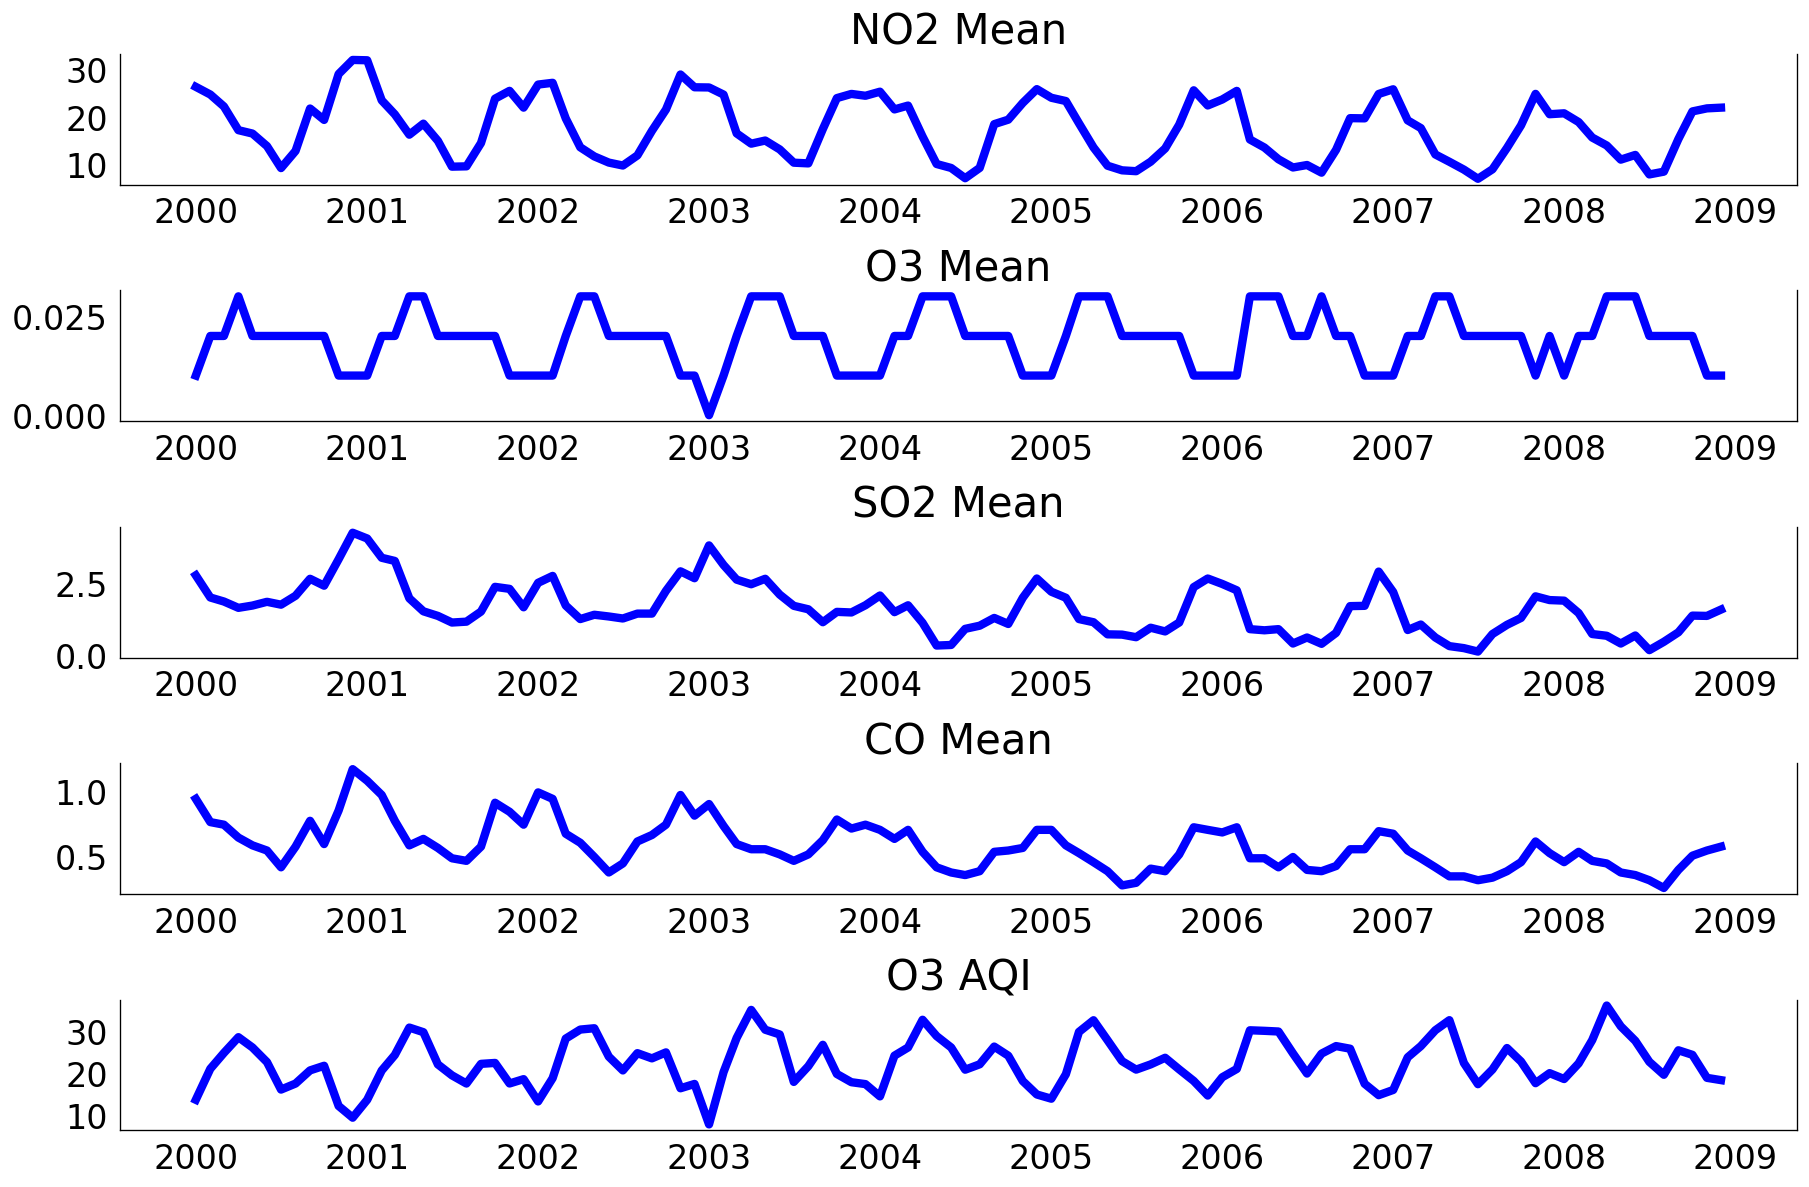

In [14]:
# Plot
fig, axes = plt.subplots(nrows=5, ncols=1, dpi=120, figsize=(15,10))
for i, ax in enumerate(axes.flatten()):
    data = pollution_df[pollution_df.columns[i]]
    ax.plot(data, color='blue', linewidth=5)
    # Decorations
    ax.set_title(pollution_df.columns[i], fontsize=25)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=20)

plt.tight_layout();

In [15]:
#questions
#1. white noise? Stationary?
#2. Trend / Seasonality?
#3. Additive / Multiplicative
#4. correlations?

In [16]:
#test stationarity
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [17]:
#Call the adfuller_test() on each series.
# ADF Test on each column
for name, column in pollution_df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "NO2 Mean" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.0736
 No. Lags Chosen       = 12
 Critical value 1%     = -3.501
 Critical value 5%     = -2.892
 Critical value 10%    = -2.583
 => P-Value = 0.2553. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "O3 Mean" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.7557
 No. Lags Chosen       = 12
 Critical value 1%     = -3.501
 Critical value 5%     = -2.892
 Critical value 10%    = -2.583
 => P-Value = 0.4027. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "SO2 Mean" 
    -----------------------------------------------
 Null Hypothesis: Dat

iteritems is deprecated and will be removed in a future version. Use .items instead.


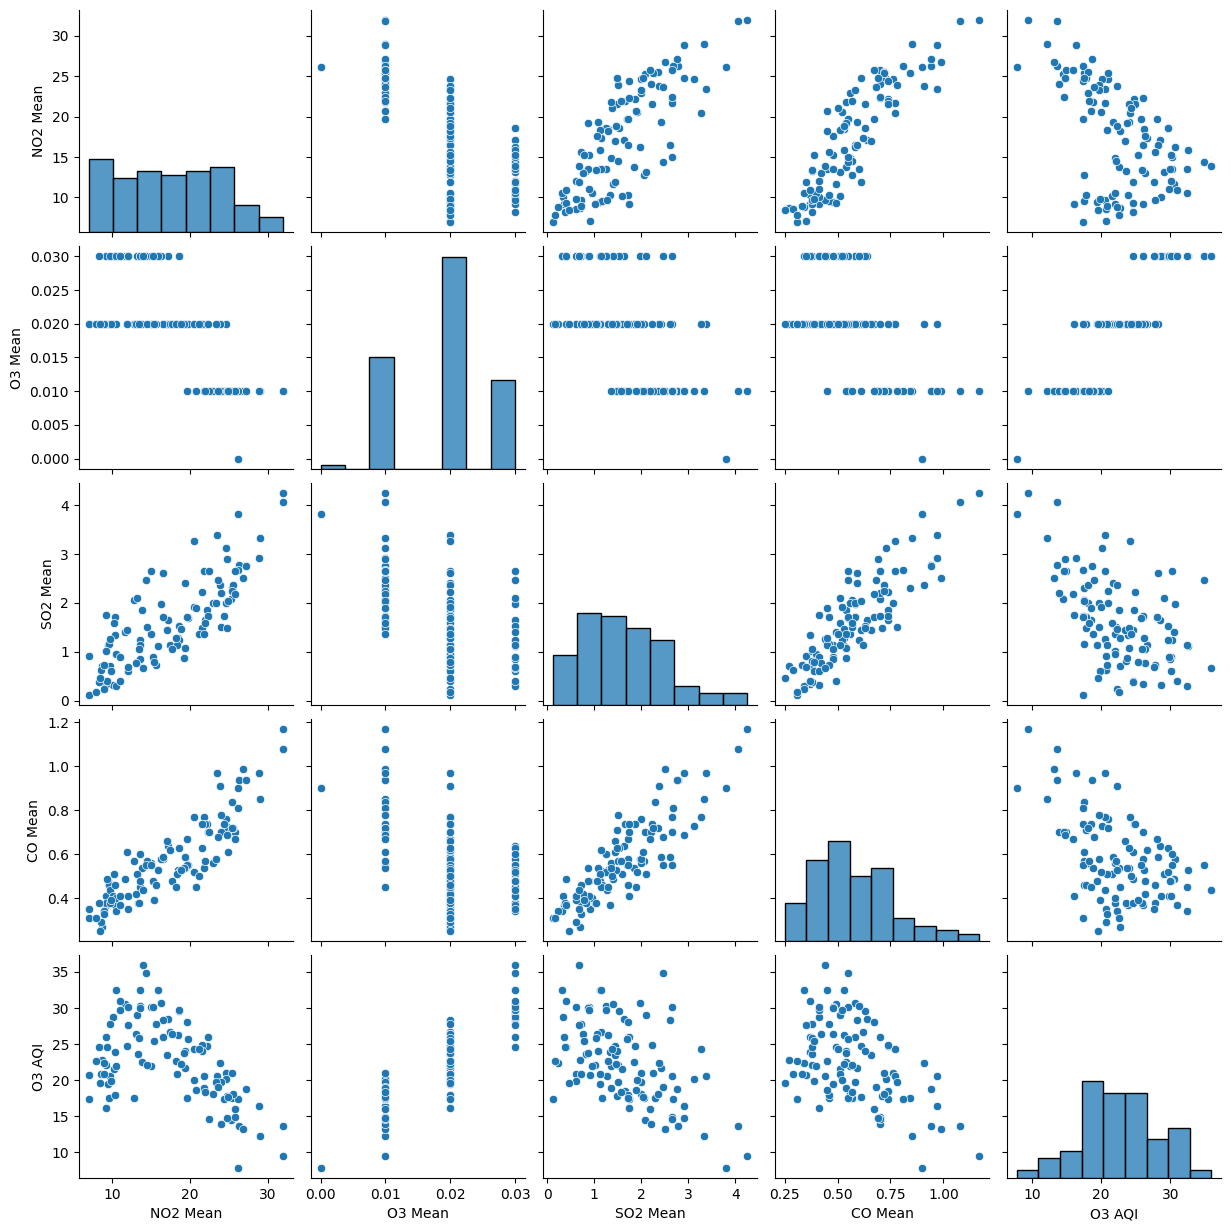

In [18]:
# Create the default pairplot
sns.pairplot(pollution_df)

In [19]:
# go to slide - Spurious Regression

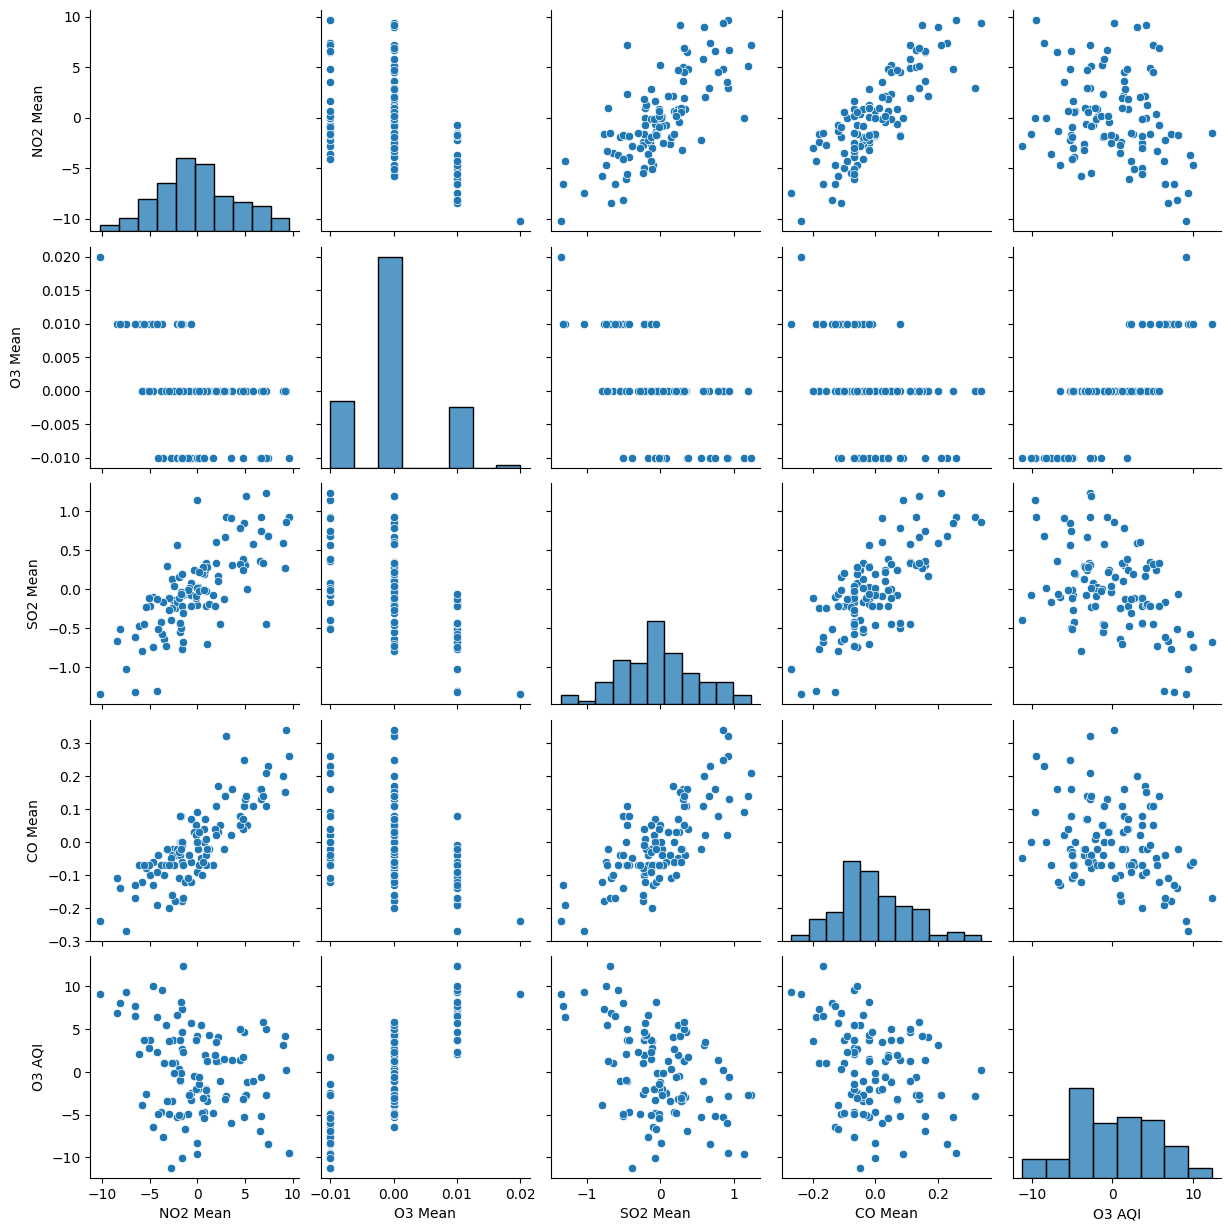

In [20]:
sns.pairplot(pollution_df.diff())

In [21]:
corr = pollution_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,NO2 Mean,O3 Mean,SO2 Mean,CO Mean,O3 AQI
NO2 Mean,1.000000,-0.680266,0.791325,0.878001,-0.512879
O3 Mean,-0.680266,1.000000,-0.567494,-0.569418,0.871924
SO2 Mean,0.791325,-0.567494,1.000000,0.860322,-0.524612
CO Mean,0.878001,-0.569418,0.860322,1.000000,-0.490223
O3 AQI,-0.512879,0.871924,-0.524612,-0.490223,1.000000


In [22]:
corr1 = pollution_df.diff().corr()
corr1.style.background_gradient(cmap='coolwarm')

,NO2 Mean,O3 Mean,SO2 Mean,CO Mean,O3 AQI
NO2 Mean,1.000000,-0.458705,0.738271,0.824228,-0.264056
O3 Mean,-0.458705,1.000000,-0.517478,-0.386666,0.783257
SO2 Mean,0.738271,-0.517478,1.000000,0.731875,-0.462940
CO Mean,0.824228,-0.386666,0.731875,1.000000,-0.321431
O3 AQI,-0.264056,0.783257,-0.462940,-0.321431,1.000000


In [23]:
corr2 = pollution_df.diff(12).corr()
corr2.style.background_gradient(cmap='coolwarm')

,NO2 Mean,O3 Mean,SO2 Mean,CO Mean,O3 AQI
NO2 Mean,1.000000,-0.219602,0.517508,0.764425,-0.197339
O3 Mean,-0.219602,1.000000,-0.204288,-0.164546,0.545606
SO2 Mean,0.517508,-0.204288,1.000000,0.491585,-0.209429
CO Mean,0.764425,-0.164546,0.491585,1.000000,-0.134521
O3 AQI,-0.197339,0.545606,-0.209429,-0.134521,1.000000


In [24]:
corr3 = pollution_df.diff().diff(12).corr()
corr3.style.background_gradient(cmap='coolwarm')

,NO2 Mean,O3 Mean,SO2 Mean,CO Mean,O3 AQI
NO2 Mean,1.000000,-0.368773,0.729058,0.786523,-0.239337
O3 Mean,-0.368773,1.000000,-0.482445,-0.269701,0.615057
SO2 Mean,0.729058,-0.482445,1.000000,0.645478,-0.365667
CO Mean,0.786523,-0.269701,0.645478,1.000000,-0.273372
O3 AQI,-0.239337,0.615057,-0.365667,-0.273372,1.000000


This approach to select variables is NOT recommended. This is invalid because it is not always possible to see the relationship from a scatterplot or correlation plots, especially when the effects of other predictors have not been accounted for.

What are the different ways to select variables?

1. VIF - https://pvanb.wordpress.com/2016/04/25/vif-stepwise-variable-selection/
2. PCA - https://builtin.com/data-science/step-step-explanation-principal-component-analysis
3. Lasso Regression - https://towardsdatascience.com/feature-selection-in-machine-learning-using-lasso-regression-7809c7c2771a
4. Various other regression techniques - https://cran.r-project.org/web/packages/olsrr/vignettes/variable_selection.html
5. RFE (Recursive Feature Elimination) - https://machinelearningmastery.com/rfe-feature-selection-in-python/

In [25]:
pollution_df

,NO2 Mean,O3 Mean,SO2 Mean,CO Mean,O3 AQI
Date Local,,,,,
2000-01-01,26.29,0.01,2.77,0.94,13.65
2000-02-01,24.67,0.02,2.00,0.76,20.97
2000-03-01,22.16,0.02,1.86,0.74,24.71
2000-04-01,17.17,0.03,1.64,0.64,28.43
2000-05-01,16.46,0.02,1.72,0.58,26.00
...,...,...,...,...,...
2008-08-01,8.44,0.02,0.46,0.25,19.55
2008-09-01,15.30,0.02,0.79,0.39,25.34
2008-10-01,21.12,0.02,1.37,0.50,24.26


In [26]:
#test = pollution_df.drop(['O3 AQI', 'NO2 Mean', 'CO Mean'], axis = 1)
test = pollution_df.drop(['O3 AQI'], axis = 1)
test

,NO2 Mean,O3 Mean,SO2 Mean,CO Mean
Date Local,,,,
2000-01-01,26.29,0.01,2.77,0.94
2000-02-01,24.67,0.02,2.00,0.76
2000-03-01,22.16,0.02,1.86,0.74
2000-04-01,17.17,0.03,1.64,0.64
2000-05-01,16.46,0.02,1.72,0.58
...,...,...,...,...
2008-08-01,8.44,0.02,0.46,0.25
2008-09-01,15.30,0.02,0.79,0.39
2008-10-01,21.12,0.02,1.37,0.50


## Multicollinearity and VIF

### What is Multicollinearity?

Multicollinearity occurs when two or more independent variables are highly correlated with one another in a regression model.

This means that an independent variable can be predicted from another independent variable in a regression model. For example, height and weight, household income and water consumption, mileage and price of a car, study time and leisure time, etc.

Let me take a simple example from our everyday life to explain this. Tanvir loves watching television while munching on chips. The more television he watches, the more chips he eats and the happier he gets!

Now, if we could quantify happiness and measure Tanvir’s happiness while he’s busy doing his favorite activity, which do you think would have a greater impact on his happiness? Having chips or watching television? That’s difficult to determine because the moment we try to measure Tanvir’s happiness from eating chips, he starts watching television. And the moment we try to measure his happiness from watching television, he starts eating chips.

Eating chips and watching television are highly correlated in the case of Tanvir and we cannot individually determine the impact of the individual activities on his happiness. This is the multicollinearity problem!

### Why is it a problem?
Multicollinearity can be a problem in a regression model because we would not be able to distinguish between the individual effects of the independent variables on the dependent variable.

### VIF - to detect multicollinearity
Multicollinearity can be detected via various methods but the most common one is VIF (Variable Inflation Factor). VIF determines the strength of the correlation between the independent variables.

1. VIF starts at 1 and has no upper limit
2. VIF = 1, no correlation between the independent variable and the other variables
3. VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

Source: https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/

In [27]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = test.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(test.values, i)
                          for i in range(len(test.columns))]

print(vif_data)

    feature        VIF
0  NO2 Mean  39.253566
1   O3 Mean   4.265136
2  SO2 Mean  17.560614
3   CO Mean  67.347296


In [28]:
#test = pollution_df.drop(['O3 AQI', 'CO Mean', 'NO2 Mean'], axis = 1)
test = pollution_df.drop(['O3 AQI', 'CO Mean'], axis = 1)


# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = test.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(test.values, i)
                          for i in range(len(test.columns))]

print(vif_data)

    feature        VIF
0  NO2 Mean  15.392356
1   O3 Mean   2.870812
2  SO2 Mean  11.934126


In [29]:
#test = pollution_df.drop(['O3 AQI', 'CO Mean', 'NO2 Mean'], axis = 1)
test = pollution_df.drop(['O3 AQI', 'CO Mean', 'NO2 Mean'], axis = 1)


# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = test.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(test.values, i)
                          for i in range(len(test.columns))]

print(vif_data)

    feature       VIF
0   O3 Mean  2.149282
1  SO2 Mean  2.149282


In [30]:
# Only selecting O3 mean and SO2 mean

In [31]:
#selecting only Ozone and SO2
pollution_df = pollution_df.drop(['NO2 Mean', 'CO Mean'], axis = 1)
pollution_df

,O3 Mean,SO2 Mean,O3 AQI
Date Local,,,
2000-01-01,0.01,2.77,13.65
2000-02-01,0.02,2.00,20.97
2000-03-01,0.02,1.86,24.71
2000-04-01,0.03,1.64,28.43
2000-05-01,0.02,1.72,26.00
...,...,...,...
2008-08-01,0.02,0.46,19.55
2008-09-01,0.02,0.79,25.34
2008-10-01,0.02,1.37,24.26


In [32]:
# convert ozone parts per million to parts per billion
pollution_df['O3 Mean'] = pollution_df['O3 Mean']*1000

In [33]:
pollution_df

,O3 Mean,SO2 Mean,O3 AQI
Date Local,,,
2000-01-01,10.0,2.77,13.65
2000-02-01,20.0,2.00,20.97
2000-03-01,20.0,1.86,24.71
2000-04-01,30.0,1.64,28.43
2000-05-01,20.0,1.72,26.00
...,...,...,...
2008-08-01,20.0,0.46,19.55
2008-09-01,20.0,0.79,25.34
2008-10-01,20.0,1.37,24.26


## Split data into train and test sets

In [34]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(pollution_df, test_size=12, random_state=25, shuffle = False)
#shuffle = False is very important to ensure the order of the data

print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")

No. of training examples: 96
No. of testing examples: 12


In [35]:
train_data

,O3 Mean,SO2 Mean,O3 AQI
Date Local,,,
2000-01-01,10.0,2.77,13.65
2000-02-01,20.0,2.00,20.97
2000-03-01,20.0,1.86,24.71
2000-04-01,30.0,1.64,28.43
2000-05-01,20.0,1.72,26.00
...,...,...,...
2007-08-01,20.0,0.73,20.81
2007-09-01,20.0,1.05,25.87
2007-10-01,20.0,1.29,22.68


In [36]:
test_data

,O3 Mean,SO2 Mean,O3 AQI
Date Local,,,
2008-01-01,10.0,1.89,18.55
2008-02-01,20.0,1.46,22.24
2008-03-01,20.0,0.73,27.74
2008-04-01,30.0,0.67,35.90
2008-05-01,30.0,0.40,31.00
2008-06-01,30.0,0.68,27.57
2008-07-01,20.0,0.17,22.61
2008-08-01,20.0,0.46,19.55
2008-09-01,20.0,0.79,25.34


## Fitting Models - Exponential Smoothing Models

### ETS - Error, Trend, Seasonailty

In [37]:
# triple ETS - Holt Winter's Seasonal Method
triple_ets_add = ExponentialSmoothing(train_data['O3 AQI'], trend = 'add', seasonal = 'add', seasonal_periods=12).fit()
triple_ets_mul = ExponentialSmoothing(train_data['O3 AQI'], trend = 'mul', seasonal = 'mul', seasonal_periods=12).fit()

triple_ets_add_pred = triple_ets_add.forecast(12)
triple_ets_mul_pred = triple_ets_mul.forecast(12)


overflow encountered in matmul


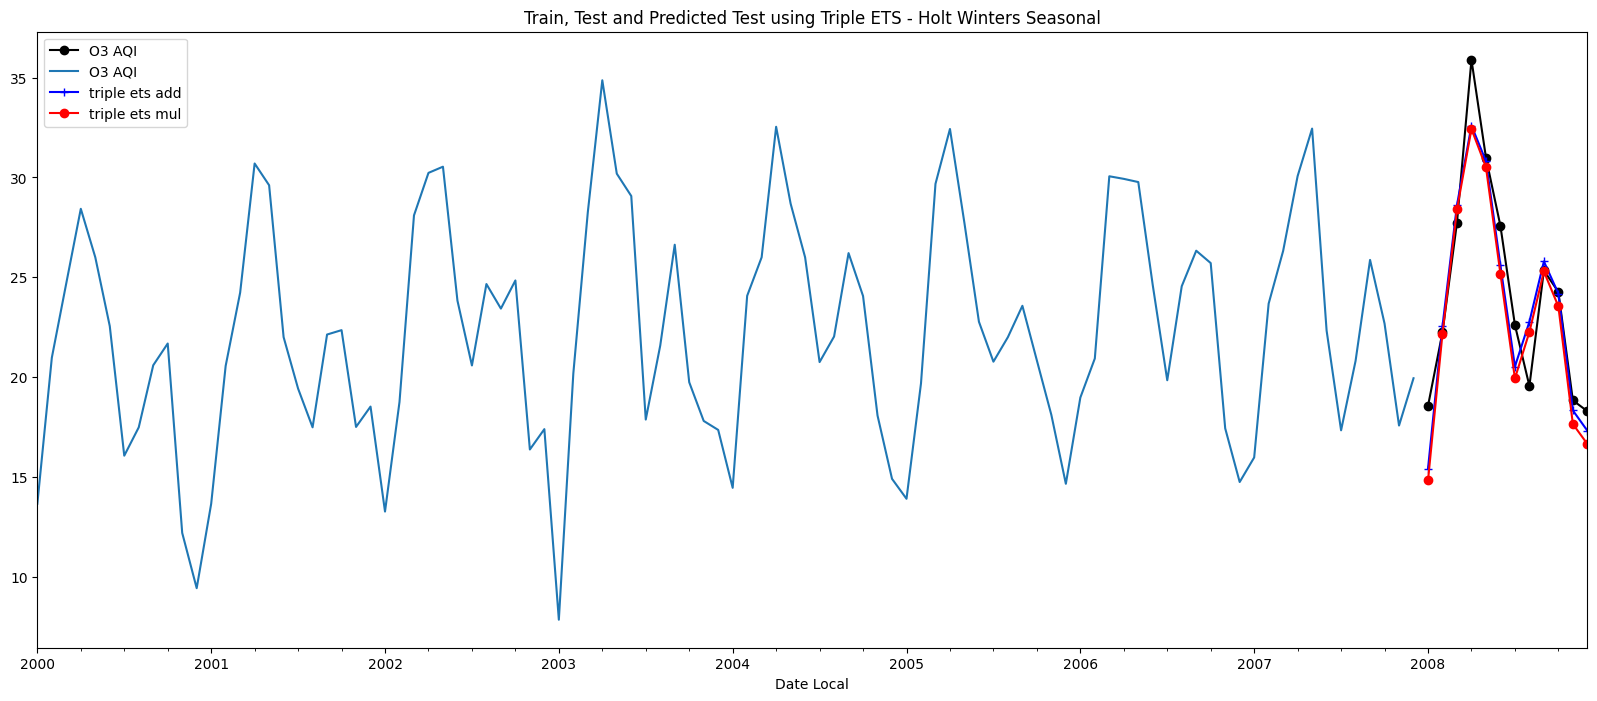

In [38]:
#plot the train, test, and predictions

#After creating model we will visualize the plot
#ax = train_data['O3 AQI'].plot(marker='o', color='black', figsize=(20,8), legend=True)
ax = test_data['O3 AQI'].plot(marker='o', color='black', figsize=(20,8), legend=True)

train_data['O3 AQI'].plot(figsize=(20,8), legend=True)
#Plot for double ETS additive
triple_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label = 'triple ets add')
#triple_ets_add.fittedvalues.plot(marker='+', ax=ax, color='blue')

#Plot for double ETS multiplicative
triple_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label = 'triple ets mul')
#triple_ets_mul.fittedvalues.plot(marker='o', ax=ax, color='red')

#Plot for simple exponential smooting alpha=Optimized by statsmodel
#ins_cast3.plot(marker='*', ax=ax, color='green', legend=True)
#ins3.fittedvalues.plot(marker='*', ax=ax, color='green')
plt.title('Train, Test and Predicted Test using Triple ETS - Holt Winters Seasonal')
plt.show()

## Auto ARIMA Seasonal

In [39]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train_data['O3 AQI'], start_p=0, start_q=0,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=466.573, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=434.076, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=444.427, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=430.326, Time=0.27 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.09 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=453.779, Time=0.22 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=425.998, Time=0.34 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=426.892, Time=0.17 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.15 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.04 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=423.015, Time=0.39 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=422.888, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   96
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -200.007
Date:                             Wed, 29 Nov 2023   AIC                            408.013
Time:                                     22:41:21   BIC                            417.689
Sample:                                 01-01-2000   HQIC                           411.900
                                      - 12-01-2007                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9241      0.062    -14.949      0.000      -1.045      -0.803
ar.S.L12      -0.5274      0.155     -3.403      0.001      -0.831      -0.224
ar.S.L24      -0.1834      0.135     -1.363      0.173      -0.447       0.080
sigma2         6.7629      0.975      6.938      0.000       4.852       8.673
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):                 1.68
Prob(Q):                              0.42   Prob(JB):                         0.43
Heteroskedasticity (H):               0.79   Skew:                             0.08
Prob(H) (two-sided):                  0.54   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
sarima_pred = smodel.predict(12)
sarima_pred = pd.Series(sarima_pred, index =test_data.index)
sarima_pred

Date Local
2008-01-01    16.854137
2008-02-01    22.232303
2008-03-01    28.454668
2008-04-01    30.686642
2008-05-01    30.890647
2008-06-01    23.423434
2008-07-01    19.056260
2008-08-01    22.546637
2008-09-01    25.838266
2008-10-01    23.614809
2008-11-01    17.850975
2008-12-01    17.412960
Freq: MS, dtype: float64

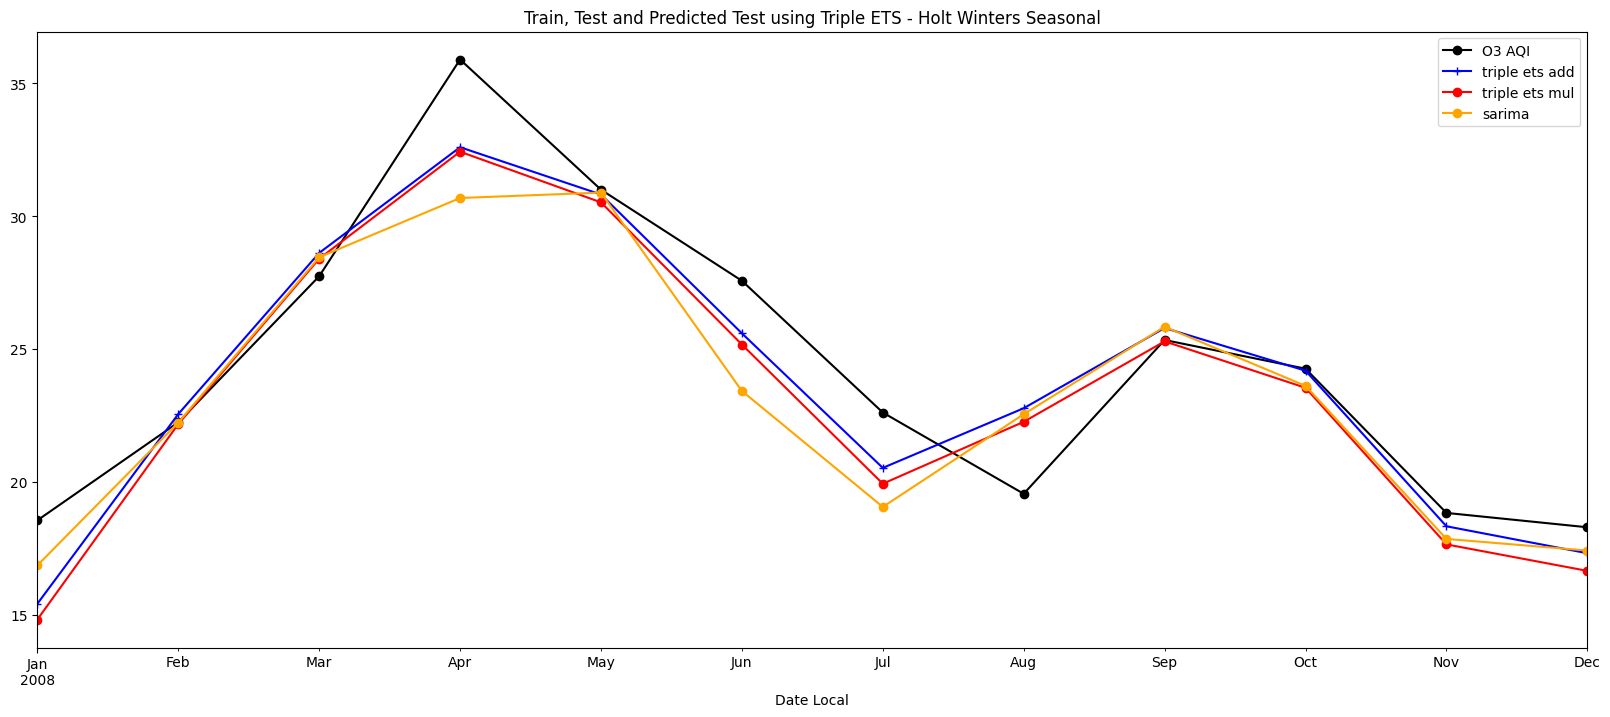

In [41]:
#plot the train, test, and predictions

#After creating model we will visualize the plot
#ax = train_data['O3 AQI'].plot(marker='o', color='black', figsize=(20,8), legend=True)
ax = test_data['O3 AQI'].plot(marker='o', color='black', figsize=(20,8), legend=True)

#train_data['O3 AQI'].plot(figsize=(20,8), legend=True)
#Plot for double ETS additive
triple_ets_add_pred.plot(marker='+', ax=ax, color='blue', legend=True, label = 'triple ets add')

#Plot for double ETS multiplicative
triple_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label = 'triple ets mul')

sarima_pred.plot(marker='o', ax=ax, color='orange', legend=True, label = 'sarima')

plt.title('Train, Test and Predicted Test using Triple ETS - Holt Winters Seasonal')
plt.show()

## VAR - Vector Autoregression

See Slides

If the series are stationary, we forecast them by fitting a VAR to the data directly (known as a “VAR in levels”). If the series are non-stationary, we take differences of the data in order to make them stationary, then fit a VAR model (known as a “VAR in differences”).

In the following case I have not differenced the datasets before running VAR. In the real world, I'll have to difference as many times as required to make the time series' stationary. Once the VAR model produces predictions, those predictions will have to be de-differenced to bring back to the right scale.

Source: https://analyticsindiamag.com/hands-on-tutorial-on-vector-autoregressionvar-for-time-series-modeling/

In [42]:
var = VAR(train_data)
x= var.select_order()
x.summary()

,AIC,BIC,FPE,HQIC
0,5.158,5.245,173.9,5.193
1,3.545,3.892*,34.64,3.684
2,3.327,3.935,27.89,3.571
3,3.199,4.067,24.60,3.548*
4,3.157,4.286,23.69,3.611
5,3.233,4.622,25.71,3.791
6,3.011*,4.660,20.79*,3.674
7,3.011,4.921,21.09,3.779
8,3.041,5.211,22.12,3.913
9,3.011,5.442,21.98,3.988


In [43]:
var_results = var.fit(6)
#We can check the summary of the model by.
var_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 29, Nov, 2023
Time:                     22:41:22
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    4.73382
Nobs:                     90.0000    HQIC:                   3.78906
Log likelihood:          -467.891    FPE:                    23.8063
AIC:                      3.15061    Det(Omega_mle):         13.4011
--------------------------------------------------------------------
Results for equation O3 Mean
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              30.289503         9.284178            3.262           0.001
L1.O3 Mean          0.327660         0.180305            1.817           0.069
L1.SO2 Mean        -2.779931         1.392094           -1.997    

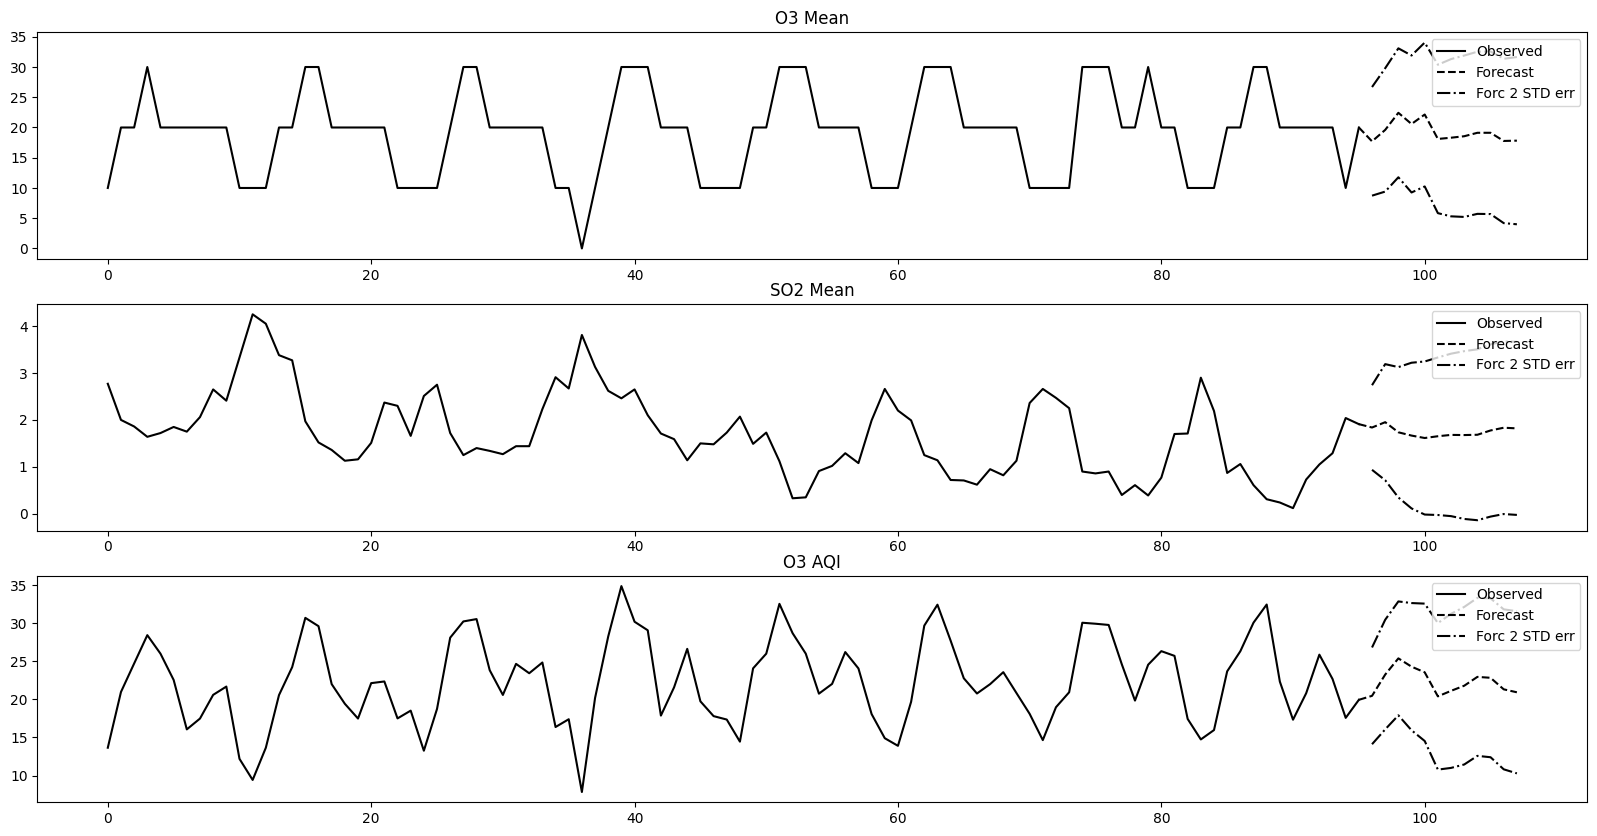

In [44]:
fig = var_results.plot_forecast(12);
fig.set_size_inches(20, 10, forward=True)


In [45]:
train_data

,O3 Mean,SO2 Mean,O3 AQI
Date Local,,,
2000-01-01,10.0,2.77,13.65
2000-02-01,20.0,2.00,20.97
2000-03-01,20.0,1.86,24.71
2000-04-01,30.0,1.64,28.43
2000-05-01,20.0,1.72,26.00
...,...,...,...
2007-08-01,20.0,0.73,20.81
2007-09-01,20.0,1.05,25.87
2007-10-01,20.0,1.29,22.68


In [46]:
#predictions
var_pred = var_results.forecast(var_results.endog, steps=12)
var_pred

array([[17.70910845,  1.83816377, 20.46137661],
       [19.60262911,  1.9517069 , 23.25581995],
       [22.42909105,  1.73636554, 25.38132363],
       [20.57826891,  1.66624131, 24.29282383],
       [22.14558596,  1.61427515, 23.5518347 ],
       [18.10611582,  1.65229509, 20.3944529 ],
       [18.30984038,  1.68065662, 21.11842536],
       [18.55412029,  1.67740209, 21.79090651],
       [19.12431029,  1.68353057, 22.95054661],
       [19.12556831,  1.77537667, 22.8314299 ],
       [17.77471091,  1.83370291, 21.31693675],
       [17.82408916,  1.81971769, 20.92850205]])

In [47]:
#converting predictions to dataframe
var_pred = pd.DataFrame(index=test_data.index,columns=[test_data.columns], data = var_pred.round(2))
var_pred

,O3 Mean,SO2 Mean,O3 AQI
Date Local,,,
2008-01-01,17.71,1.84,20.46
2008-02-01,19.60,1.95,23.26
2008-03-01,22.43,1.74,25.38
2008-04-01,20.58,1.67,24.29
2008-05-01,22.15,1.61,23.55
2008-06-01,18.11,1.65,20.39
2008-07-01,18.31,1.68,21.12
2008-08-01,18.55,1.68,21.79
2008-09-01,19.12,1.68,22.95


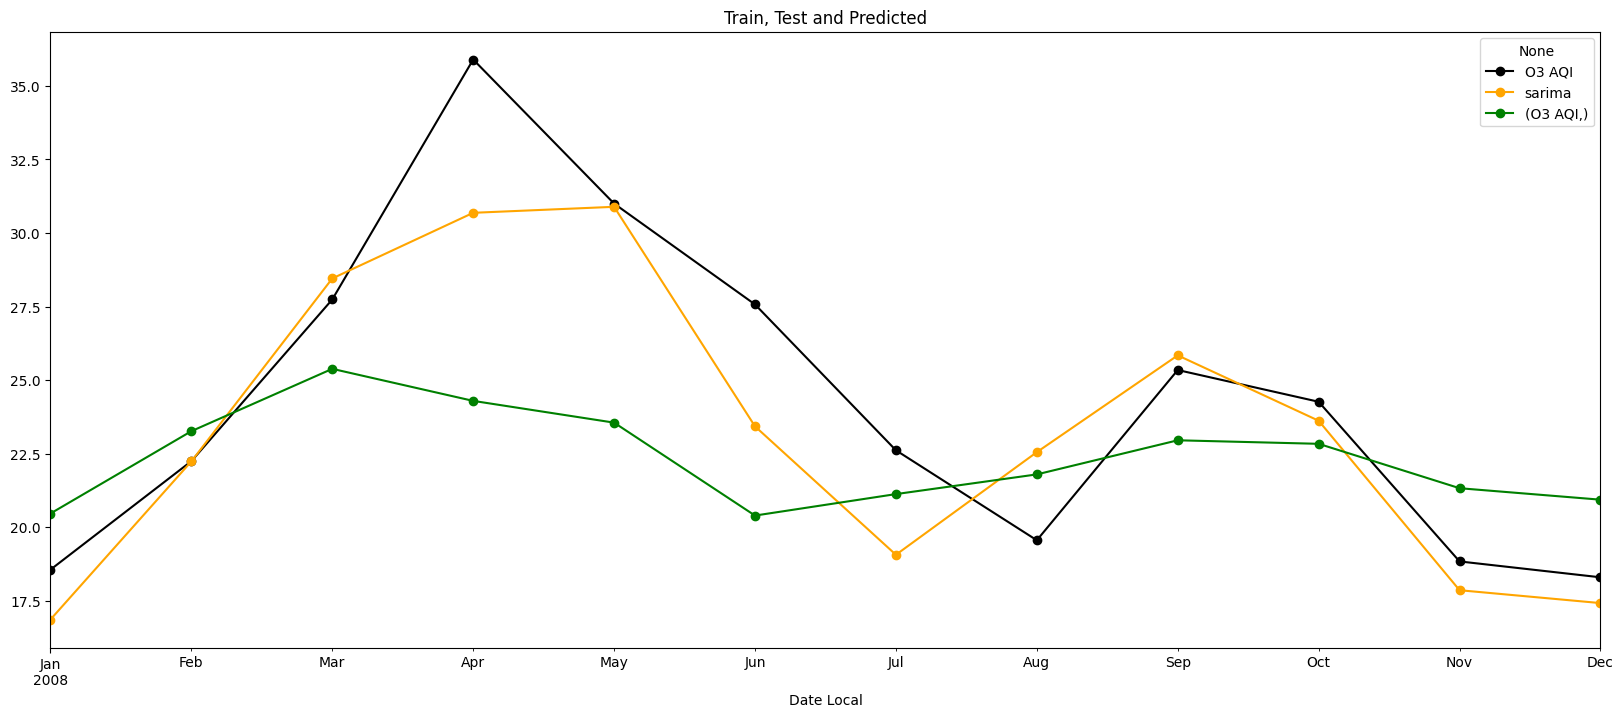

In [48]:
#plot the train, test, and predictions

#After creating model we will visualize the plot
#ax = train_data['O3 AQI'].plot(marker='o', color='black', figsize=(20,8), legend=True)
ax = test_data['O3 AQI'].plot(marker='o', color='black', figsize=(20,8), legend=True)

#train_data['O3 AQI'].plot(figsize=(20,8), legend=True)
#Plot for double ETS additive
#triple_ets_add_pred.plot(marker='o', ax=ax, color='blue', legend=True, label = 'triple ets add')

#Plot for double ETS multiplicative
#triple_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label = 'triple ets mul')

sarima_pred.plot(marker='o', ax=ax, color='orange', legend=True, label = 'sarima')

var_pred['O3 AQI'].plot(marker='o', ax=ax, color='green', legend=True, label = 'var')

plt.title('Train, Test and Predicted')
plt.show()

In [49]:
#Call the adfuller_test() on each series.
# ADF Test on each column
for name, column in train_data.diff(12).dropna().iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "O3 Mean" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.7379
 No. Lags Chosen       = 0
 Critical value 1%     = -3.512
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "SO2 Mean" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.0191
 No. Lags Chosen       = 11
 Critical value 1%     = -3.525
 Critical value 5%     = -2.903
 Critical value 10%    = -2.589
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "O3 AQI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level 

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [50]:
#seasonal difference the series to make it stationary
train_data_seasonal_diff = train_data.diff(12).dropna()
var_diff = VAR(train_data_seasonal_diff)
x_diff = var.select_order()
x_diff.summary()

,AIC,BIC,FPE,HQIC
0,5.158,5.245,173.9,5.193
1,3.545,3.892*,34.64,3.684
2,3.327,3.935,27.89,3.571
3,3.199,4.067,24.60,3.548*
4,3.157,4.286,23.69,3.611
5,3.233,4.622,25.71,3.791
6,3.011*,4.660,20.79*,3.674
7,3.011,4.921,21.09,3.779
8,3.041,5.211,22.12,3.913
9,3.011,5.442,21.98,3.988


In [51]:
var_results_diff = var_diff.fit(6)
#We can check the summary of the model by.
var_results_diff.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 29, Nov, 2023
Time:                     22:41:24
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    5.74466
Nobs:                     78.0000    HQIC:                   4.71189
Log likelihood:          -431.907    FPE:                    57.5375
AIC:                      4.02245    Det(Omega_mle):         29.9171
--------------------------------------------------------------------
Results for equation O3 Mean
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.412202         0.569265            0.724           0.469
L1.O3 Mean          0.078584         0.170809            0.460           0.645
L1.SO2 Mean        -0.410849         1.231339           -0.334    

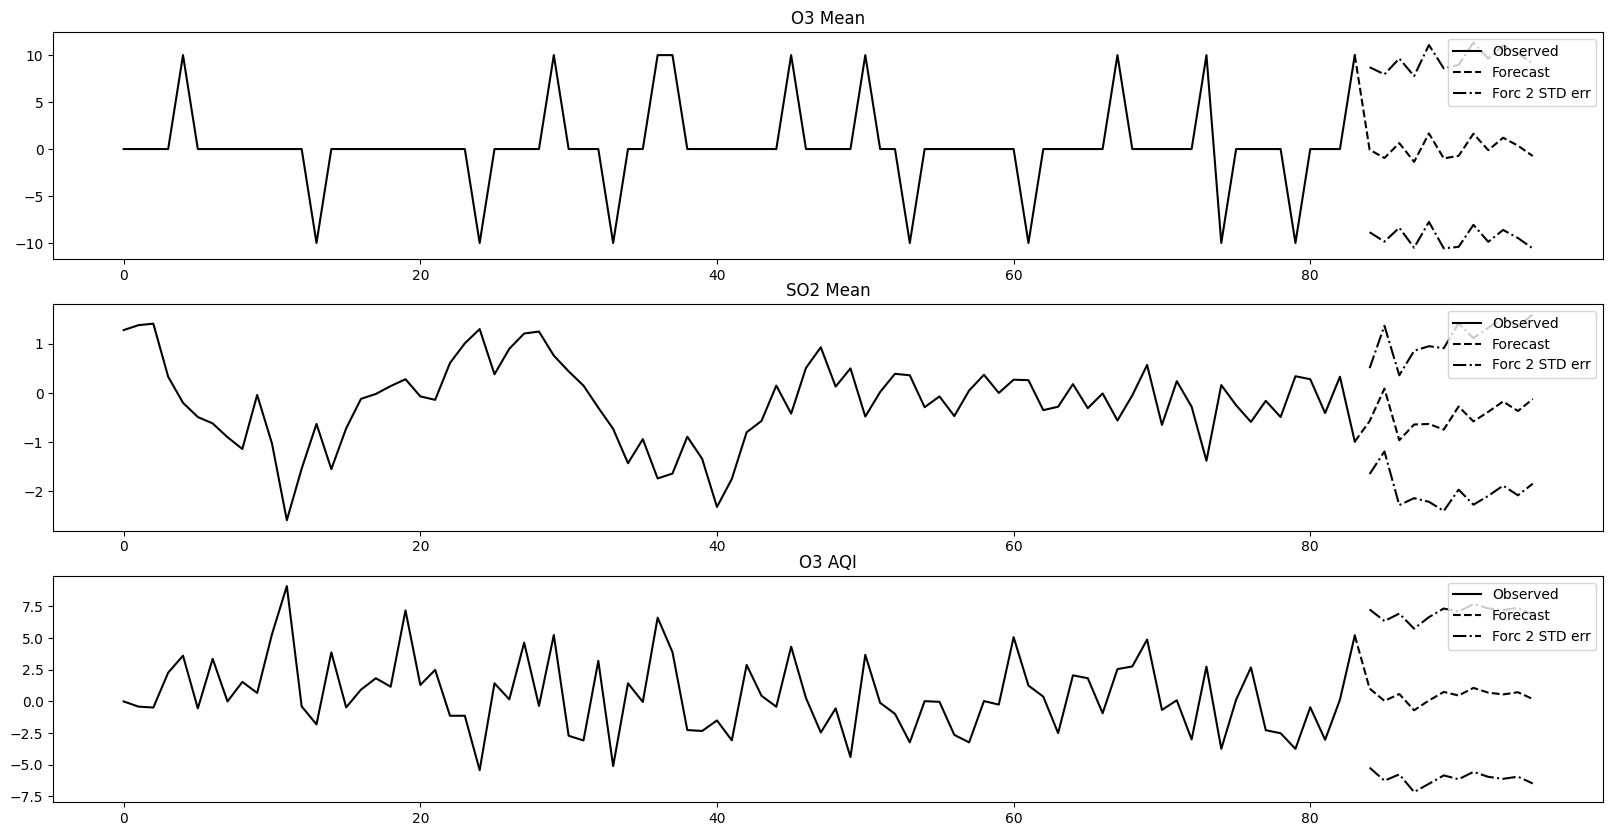

In [52]:
fig = var_results_diff.plot_forecast(12);
fig.set_size_inches(20, 10, forward=True)


In [53]:
#predictions
var_pred_diff = var_results_diff.forecast(train_data_seasonal_diff.values[-12:], steps=12)
var_pred_diff

array([[-0.07024383, -0.57324549,  1.01633345],
       [-0.95298904,  0.08891374,  0.04390066],
       [ 0.63111602, -0.96144177,  0.58746431],
       [-1.36492104, -0.64172197, -0.70068794],
       [ 1.66128561, -0.63139808,  0.07618686],
       [-0.99352036, -0.74519648,  0.74809766],
       [-0.72656639, -0.27556932,  0.46819139],
       [ 1.63422393, -0.57918012,  1.06707469],
       [-0.12177622, -0.38395496,  0.69570302],
       [ 1.20275006, -0.17396427,  0.55192247],
       [ 0.36173067, -0.36742952,  0.7247113 ],
       [-0.74370709, -0.12310507,  0.18861812]])

In [54]:
# Invert the seasonal differencing
forecast_inverted = var_pred_diff + train_data.values[-12:,:]
forecast_inverted

array([[ 9.92975617e+00,  1.61675451e+00,  1.69863334e+01],
       [ 1.90470110e+01,  9.58913738e-01,  2.37239007e+01],
       [ 2.06311160e+01,  9.85582326e-02,  2.69074643e+01],
       [ 2.86350790e+01, -3.17219653e-02,  2.93693121e+01],
       [ 3.16612856e+01, -3.21398081e-01,  3.25261869e+01],
       [ 1.90064796e+01, -5.05196481e-01,  2.30780977e+01],
       [ 1.92734336e+01, -1.55569323e-01,  1.77981914e+01],
       [ 2.16342239e+01,  1.50819883e-01,  2.18770747e+01],
       [ 1.98782238e+01,  6.66045042e-01,  2.65657030e+01],
       [ 2.12027501e+01,  1.11603573e+00,  2.32319225e+01],
       [ 1.03617307e+01,  1.67257048e+00,  1.82947113e+01],
       [ 1.92562929e+01,  1.78689493e+00,  2.01286181e+01]])

In [55]:
var_pred['Inverted Results O3 AQI'] = forecast_inverted[:, -1]
var_pred

,O3 Mean,SO2 Mean,O3 AQI,Inverted Results O3 AQI
Date Local,,,,
2008-01-01,17.71,1.84,20.46,16.986333
2008-02-01,19.60,1.95,23.26,23.723901
2008-03-01,22.43,1.74,25.38,26.907464
2008-04-01,20.58,1.67,24.29,29.369312
2008-05-01,22.15,1.61,23.55,32.526187
2008-06-01,18.11,1.65,20.39,23.078098
2008-07-01,18.31,1.68,21.12,17.798191
2008-08-01,18.55,1.68,21.79,21.877075
2008-09-01,19.12,1.68,22.95,26.565703


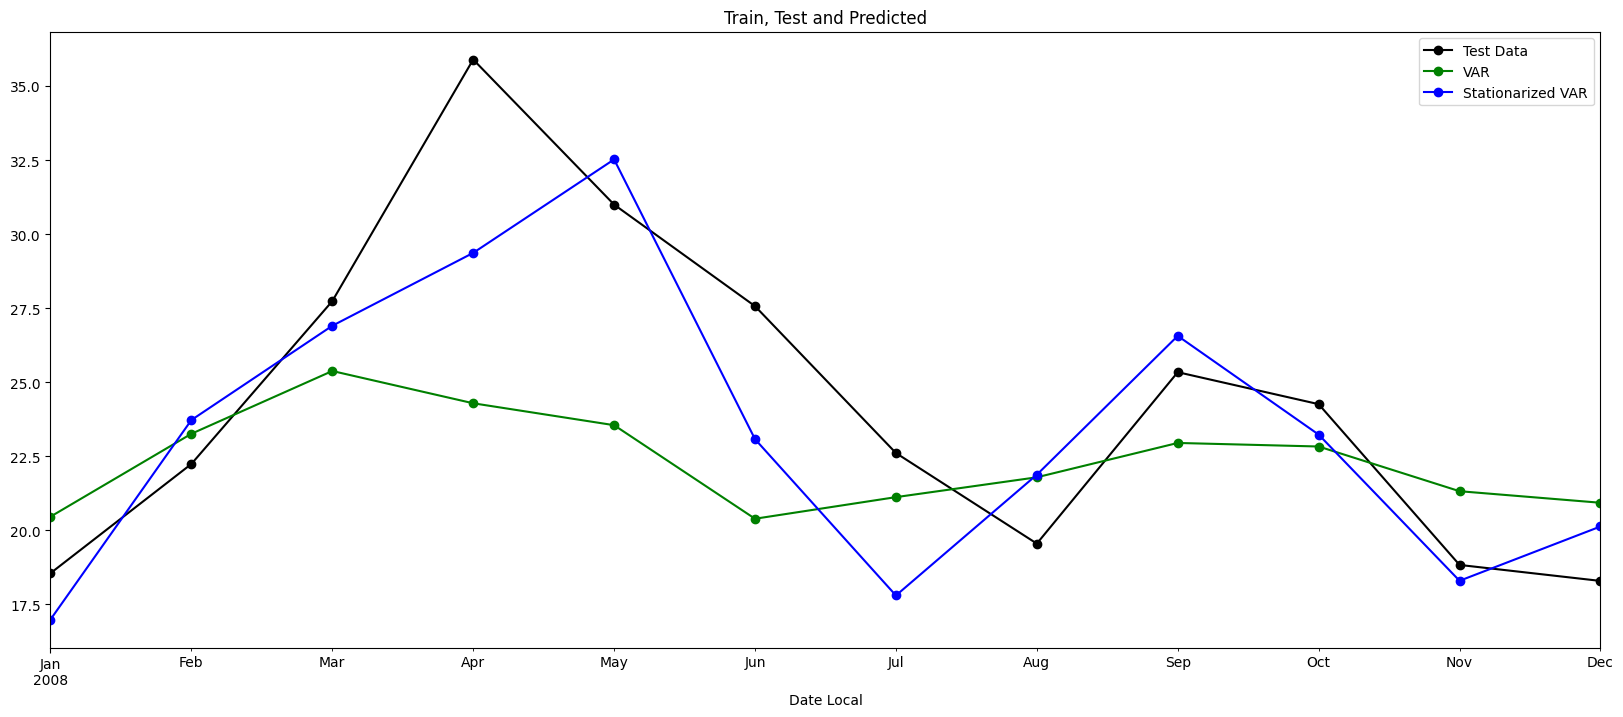

In [56]:
##plot the train, test, and predictions

#After creating model we will visualize the plot
#ax = train_data['O3 AQI'].plot(marker='o', color='black', figsize=(20,8), legend=True)
ax = test_data['O3 AQI'].plot(marker='o', color='black', figsize=(20,8), legend=True, label='Test Data')

#sarima_pred.plot(marker='o', ax=ax, color='orange', legend=True, label = 'sarima')

var_pred['O3 AQI'].plot(marker='o', ax=ax, color='green', legend=True, label = 'VAR')
var_pred['Inverted Results O3 AQI'].plot(marker='o', ax=ax, color='blue', legend=True, label = 'VAR after Diff')
ax.legend(['Test Data', 'VAR', 'Stationarized VAR'])
plt.title('Train, Test and Predicted')
plt.show()

### SARIMAX model

SARIMAX(Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors) is an updated version of the ARIMA model. ARIMA includes an autoregressive integrated moving average, while SARIMAX includes seasonal effects and eXogenous factors with the autoregressive and moving average component in the model.

#### Exogenous vs Endogenous Variables
Exogenous variables are independent, and endogenous variables are dependent. Therefore, if the variable does not depend on variables within the model, it's an exogenous variable. However, if the variable depends on variables within the model, it's an endogenous variable.

https://www.indeed.com/career-advice/career-development/exogenous-variable#:~:text=Exogenous%20variables%20are%20independent%2C%20and,model%2C%20it's%20an%20endogenous%20variable.

In [57]:
# Define SARIMA parameters
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]  # Assumes seasonal period is 12 months (annual seasonality)

best_aic = np.inf
best_order = None
best_seasonal_order = None

# Find the best SARIMA-X model
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.SARIMAX(train_data['O3 AQI'],
                                exog=train_data[['O3 Mean', 'SO2 Mean']],
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal
        except:
            continue

Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals


In [58]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [59]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [60]:
best_order

(1, 0, 1)

In [61]:
best_seasonal_order

(0, 1, 1, 12)

                                     SARIMAX Results                                      
Dep. Variable:                             O3 AQI   No. Observations:                   96
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -141.922
Date:                            Wed, 29 Nov 2023   AIC                            295.843
Time:                                    22:41:46   BIC                            309.334
Sample:                                01-01-2000   HQIC                           301.202
                                     - 12-01-2007                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
O3 Mean        0.3649      0.078      4.650      0.000       0.211       0.519
SO2 Mean       0.3947      0.453   

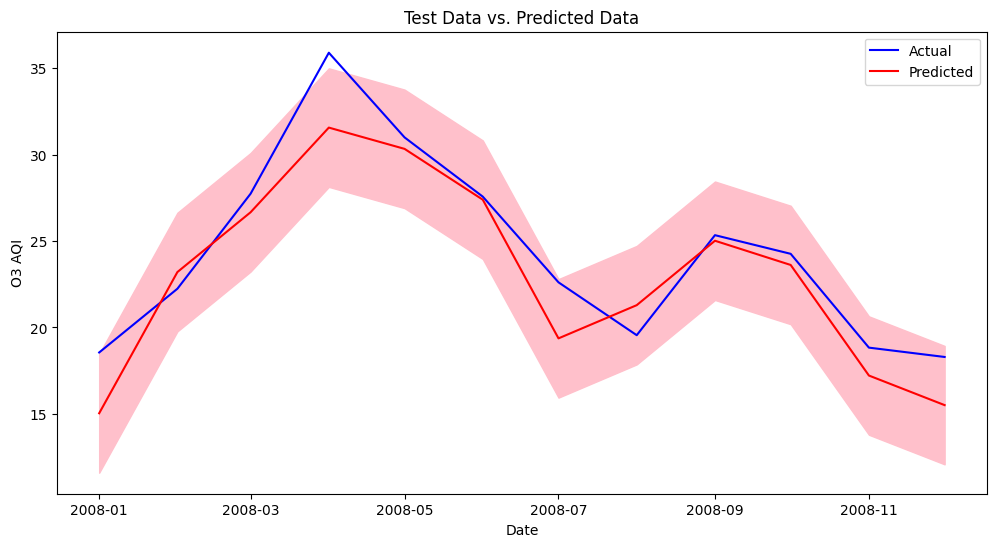

In [62]:


# Fit the best SARIMA-X model
final_mod = sm.tsa.SARIMAX(train_data['O3 AQI'],
                           exog=train_data[['O3 Mean', 'SO2 Mean']],
                           order=best_order,
                           seasonal_order=best_seasonal_order,
                           enforce_stationarity=False,
                           enforce_invertibility=False)
final_results = final_mod.fit()

# Print the model summary
print(final_results.summary())

# Make predictions on test data
test_predictions = final_results.get_forecast(steps=len(test_data), exog=test_data[['O3 Mean', 'SO2 Mean']])
sarimax_pred = test_predictions.predicted_mean
predicted_conf_int = test_predictions.conf_int()

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['O3 AQI'], label='Actual', color='blue')
plt.plot(test_data.index, sarimax_pred, label='Predicted', color='red')
plt.fill_between(test_data.index, predicted_conf_int.iloc[:, 0], predicted_conf_int.iloc[:, 1], color='pink')
plt.xlabel('Date')
plt.ylabel('O3 AQI')
plt.title('Test Data vs. Predicted Data')
plt.legend()
plt.show()

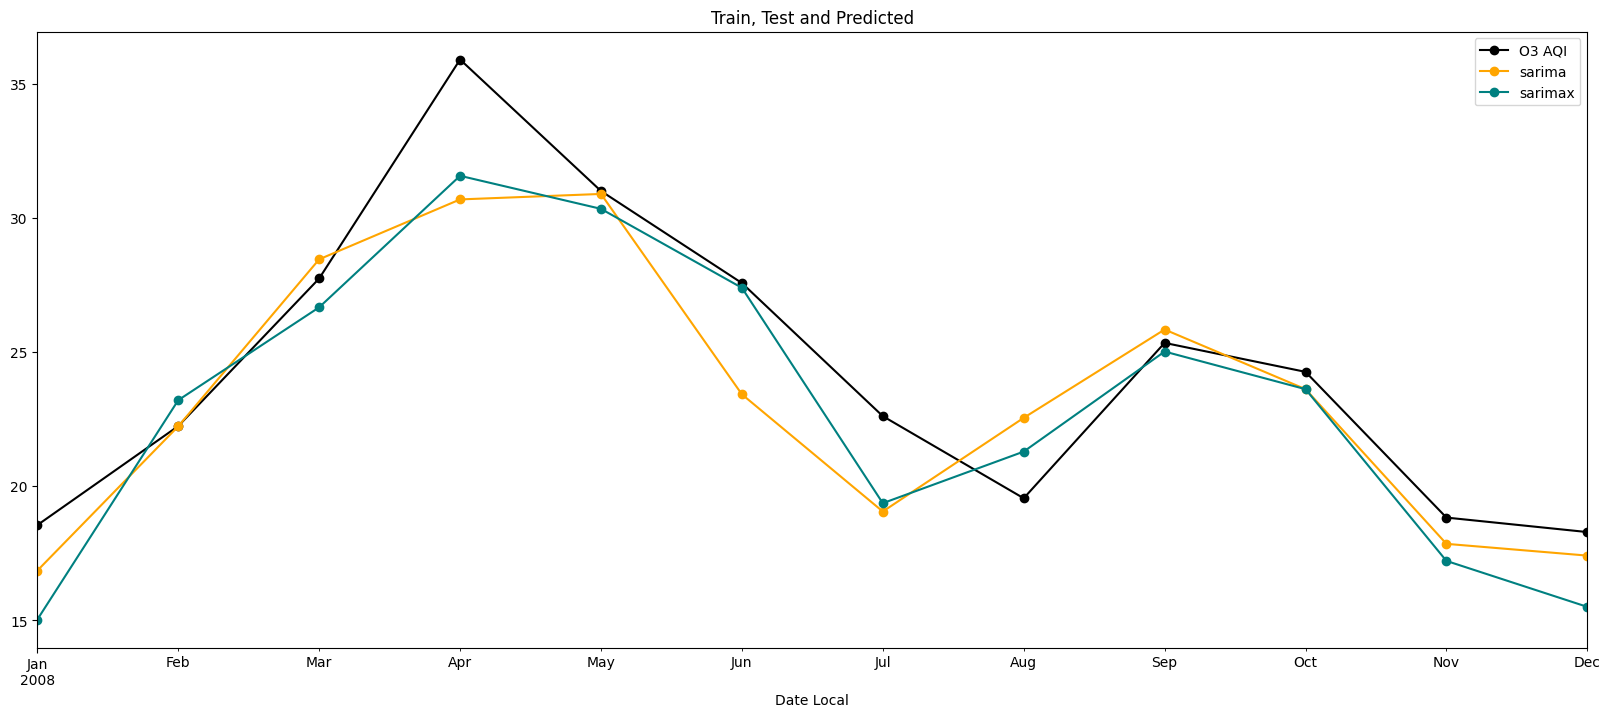

In [63]:
#plot the train, test, and predictions

#After creating model we will visualize the plot
#ax = train_data['O3 AQI'].plot(marker='o', color='black', figsize=(20,8), legend=True)
ax = test_data['O3 AQI'].plot(marker='o', color='black', figsize=(20,8), legend=True)

#train_data['O3 AQI'].plot(figsize=(20,8), legend=True)
#Plot for double ETS additive
#triple_ets_add_pred.plot(marker='o', ax=ax, color='blue', legend=True, label = 'triple ets add')

#Plot for double ETS multiplicative
#triple_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label = 'triple ets mul')

sarima_pred.plot(marker='o', ax=ax, color='orange', legend=True, label = 'sarima')

#var_pred['O3 AQI'].plot(marker='o', ax=ax, color='green', legend=True, label = 'Vector AutoRegression')

sarimax_pred.plot(marker='o', ax=ax, color='teal', legend=True, label = 'sarimax')

plt.title('Train, Test and Predicted')
plt.show()

### Metrics - model evaluation

In [64]:
#define metrics dataframe which will be used below for
metrics_dataframe = pd.DataFrame(columns=['Model', 'R2', 'RMSE', 'MAE', 'MAPE'])


def metrics_cal(actuals, predictions, model):
    print()
    r2 = metrics.r2_score(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    df = pd.DataFrame({'Model': model,
                       'R2': r2,
                       'RMSE': rmse,
                       'MAE': mae,
                       'MAPE': mape}, index=[0])
    dataframe = metrics_dataframe.append(df)
    return dataframe

In [65]:
#get all the metrics
metrics_dataframe = metrics_cal(test_data['O3 AQI'].values.flatten(),
                                triple_ets_add_pred.values.flatten(),
                                'Triple Add')

metrics_dataframe = metrics_cal(test_data['O3 AQI'].values.flatten(),
                                triple_ets_mul_pred.values.flatten(),
                                'Triple Mul')


metrics_dataframe = metrics_cal(test_data['O3 AQI'].values.flatten(),
                                sarima_pred.values.flatten(),
                                'SARIMA')

metrics_dataframe = metrics_cal(test_data['O3 AQI'].values.flatten(),
                                var_pred['O3 AQI'].values.flatten(),
                                'VAR')

metrics_dataframe = metrics_cal(test_data['O3 AQI'].values.flatten(),
                                var_pred['Inverted Results O3 AQI'].values.flatten(),
                                'VAR_Diff12')

metrics_dataframe = metrics_cal(test_data['O3 AQI'].values.flatten(),
                                sarimax_pred.values.flatten(),
                                'SARIMAX')


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [66]:
metrics_dataframe.sort_values(by="MAE", ascending=True)

,Model,R2,RMSE,MAE,MAPE
0,Triple Add,0.874245,1.864755,1.425672,6.189420
0,Triple Mul,0.844590,2.072999,1.649735,7.239532
0,SARIMAX,0.824703,2.201645,1.757271,7.752781
0,SARIMA,0.783698,2.445625,1.786451,7.277811
0,VAR_Diff12,0.682684,2.962144,2.349621,9.388767
0,VAR,0.155354,4.832783,3.684167,13.903083


## Multivariate ML Forecasting

In [67]:
train_data

,O3 Mean,SO2 Mean,O3 AQI
Date Local,,,
2000-01-01,10.0,2.77,13.65
2000-02-01,20.0,2.00,20.97
2000-03-01,20.0,1.86,24.71
2000-04-01,30.0,1.64,28.43
2000-05-01,20.0,1.72,26.00
...,...,...,...
2007-08-01,20.0,0.73,20.81
2007-09-01,20.0,1.05,25.87
2007-10-01,20.0,1.29,22.68


#### Q1. What are the leading indicators that explain the average Ozone Air Quality Index over the next 12 months?

First, create the response or dependent varaible that you are interested in predicting.

Add useful predictors/explanatory variables/independent variables to the dataset which are as follows.

1. Trend, Seasonality, Error - time series decomposition
2. Dummy variables - mm/dd/yyyy (seasonal dates), public holiday or not, outliers, categorical variables (beware of dummy variable trap - add one less than the uniqque number of categories)
https://www.geeksforgeeks.org/ml-dummy-variable-trap-in-regression-models/

3. Fourier Series - An alternative to using seasonal dummy variables, especially for long seasonal periods. With Fourier terms, we often need fewer predictors than with dummy variables, especially when seasonal period are large. This makes them useful for weekly data. For short seasonal periods (e.g., quarterly data), there is little advantage in using Fourier terms over seasonal dummy variables.
4. Lag values - It is often useful to include advertising expenditure as a predictor. However, since the effect of advertising can last beyond the actual campaign, we need to include lagged values of advertising expenditure.
5. Rolling and expanding window calculations
6. Intervention variables - competitor activity, advertising expenditure, industrial action, piecewise linear trend that bends at the time of intervention and hence is nonlinear.
7. No of trading days in a month

Source: https://otexts.com/fpp2/useful-predictors.html

In [68]:
# create lagged values

# create past 3 months' lagged values for ozone, so2, and ozone aqi

lagged_train_data = train_data.copy()
trailing_window_size = 3

for window in range(1, trailing_window_size + 1):
    shifted = train_data.shift(window)
    shifted.columns = [x + "_lag-" + str(window) for x in train_data.columns]
    lagged_train_data = pd.concat((lagged_train_data, shifted), axis=1)

lagged_train_data


,O3 Mean,SO2 Mean,O3 AQI,O3 Mean_lag-1,SO2 Mean_lag-1,O3 AQI_lag-1,O3 Mean_lag-2,SO2 Mean_lag-2,O3 AQI_lag-2,O3 Mean_lag-3,SO2 Mean_lag-3,O3 AQI_lag-3
Date Local,,,,,,,,,,,,
2000-01-01,10.0,2.77,13.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,20.0,2.00,20.97,10.0,2.77,13.65,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-01,20.0,1.86,24.71,20.0,2.00,20.97,10.0,2.77,13.65,NaN,NaN,NaN
2000-04-01,30.0,1.64,28.43,20.0,1.86,24.71,20.0,2.00,20.97,10.0,2.77,13.65
2000-05-01,20.0,1.72,26.00,30.0,1.64,28.43,20.0,1.86,24.71,20.0,2.00,20.97
...,...,...,...,...,...,...,...,...,...,...,...,...
2007-08-01,20.0,0.73,20.81,20.0,0.12,17.33,20.0,0.24,22.33,30.0,0.31,32.45
2007-09-01,20.0,1.05,25.87,20.0,0.73,20.81,20.0,0.12,17.33,20.0,0.24,22.33
2007-10-01,20.0,1.29,22.68,20.0,1.05,25.87,20.0,0.73,20.81,20.0,0.12,17.33


In [69]:
lagged_train_data = lagged_train_data.dropna()
lagged_train_data


,O3 Mean,SO2 Mean,O3 AQI,O3 Mean_lag-1,SO2 Mean_lag-1,O3 AQI_lag-1,O3 Mean_lag-2,SO2 Mean_lag-2,O3 AQI_lag-2,O3 Mean_lag-3,SO2 Mean_lag-3,O3 AQI_lag-3
Date Local,,,,,,,,,,,,
2000-04-01,30.0,1.64,28.43,20.0,1.86,24.71,20.0,2.00,20.97,10.0,2.77,13.65
2000-05-01,20.0,1.72,26.00,30.0,1.64,28.43,20.0,1.86,24.71,20.0,2.00,20.97
2000-06-01,20.0,1.85,22.55,20.0,1.72,26.00,30.0,1.64,28.43,20.0,1.86,24.71
2000-07-01,20.0,1.75,16.06,20.0,1.85,22.55,20.0,1.72,26.00,30.0,1.64,28.43
2000-08-01,20.0,2.06,17.48,20.0,1.75,16.06,20.0,1.85,22.55,20.0,1.72,26.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2007-08-01,20.0,0.73,20.81,20.0,0.12,17.33,20.0,0.24,22.33,30.0,0.31,32.45
2007-09-01,20.0,1.05,25.87,20.0,0.73,20.81,20.0,0.12,17.33,20.0,0.24,22.33
2007-10-01,20.0,1.29,22.68,20.0,1.05,25.87,20.0,0.73,20.81,20.0,0.12,17.33


In [70]:
lagged_train_data.columns

Index(['O3 Mean', 'SO2 Mean', 'O3 AQI', 'O3 Mean_lag-1', 'SO2 Mean_lag-1',
       'O3 AQI_lag-1', 'O3 Mean_lag-2', 'SO2 Mean_lag-2', 'O3 AQI_lag-2',
       'O3 Mean_lag-3', 'SO2 Mean_lag-3', 'O3 AQI_lag-3'],
      dtype='object')

In [71]:
#create trend, seasonality, and error (ETS)

def create_trend_seasonality_error(data):
    cols = ['O3 Mean', 'SO2 Mean', 'O3 AQI']
    for col in cols:
        #print(col)
        res = sm.tsa.seasonal_decompose(data[col], period=12, extrapolate_trend='freq')
        # extract the decomposed terms
        data[col+'_trend'] = res.trend
        data[col+'_seasonal'] = res.seasonal
        data[col+'_error'] = res.resid
    return data

In [72]:
ets_train_data = create_trend_seasonality_error(lagged_train_data.copy())

In [73]:
ets_train_data

,O3 Mean,SO2 Mean,O3 AQI,O3 Mean_lag-1,SO2 Mean_lag-1,O3 AQI_lag-1,O3 Mean_lag-2,SO2 Mean_lag-2,O3 AQI_lag-2,O3 Mean_lag-3,...,O3 AQI_lag-3,O3 Mean_trend,O3 Mean_seasonal,O3 Mean_error,SO2 Mean_trend,SO2 Mean_seasonal,SO2 Mean_error,O3 AQI_trend,O3 AQI_seasonal,O3 AQI_error
Date Local,,,,,,,,,,,,,,,,,,,,,
2000-04-01,30.0,1.64,28.43,20.0,1.86,24.71,20.0,2.00,20.97,10.0,...,13.65,18.958333,10.844019,0.197647,3.305594,-0.460114,-1.205481,18.256698,9.127130,1.046172
2000-05-01,20.0,1.72,26.00,30.0,1.64,28.43,20.0,1.86,24.71,20.0,...,20.97,18.958333,9.594019,-8.552353,3.227354,-0.625282,-0.882073,18.450022,7.289735,0.260243
2000-06-01,20.0,1.85,22.55,20.0,1.72,26.00,30.0,1.64,28.43,20.0,...,24.71,18.958333,3.291936,-2.250269,3.149114,-0.746595,-0.552519,18.643347,1.956507,1.950146
2000-07-01,20.0,1.75,16.06,20.0,1.85,22.55,20.0,1.72,26.00,30.0,...,28.43,18.958333,0.858527,0.183139,3.070874,-0.741141,-0.579733,18.836672,-3.140821,0.364149
2000-08-01,20.0,2.06,17.48,20.0,1.75,16.06,20.0,1.85,22.55,20.0,...,26.00,18.958333,2.121457,-1.079790,2.992634,-0.553549,-0.379085,19.029996,-0.935273,-0.614723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-08-01,20.0,0.73,20.81,20.0,0.12,17.33,20.0,0.24,22.33,30.0,...,32.45,18.947164,2.121457,-1.068621,0.994189,-0.553549,0.289360,22.344261,-0.935273,-0.598988
2007-09-01,20.0,1.05,25.87,20.0,0.73,20.81,20.0,0.12,17.33,20.0,...,22.33,18.843726,0.884387,0.271887,0.973771,-0.350383,0.426612,22.249889,2.046472,1.573639
2007-10-01,20.0,1.29,22.68,20.0,1.05,25.87,20.0,0.73,20.81,20.0,...,17.33,18.740287,-0.274558,1.534271,0.953353,0.076260,0.260387,22.155517,0.407590,0.116893


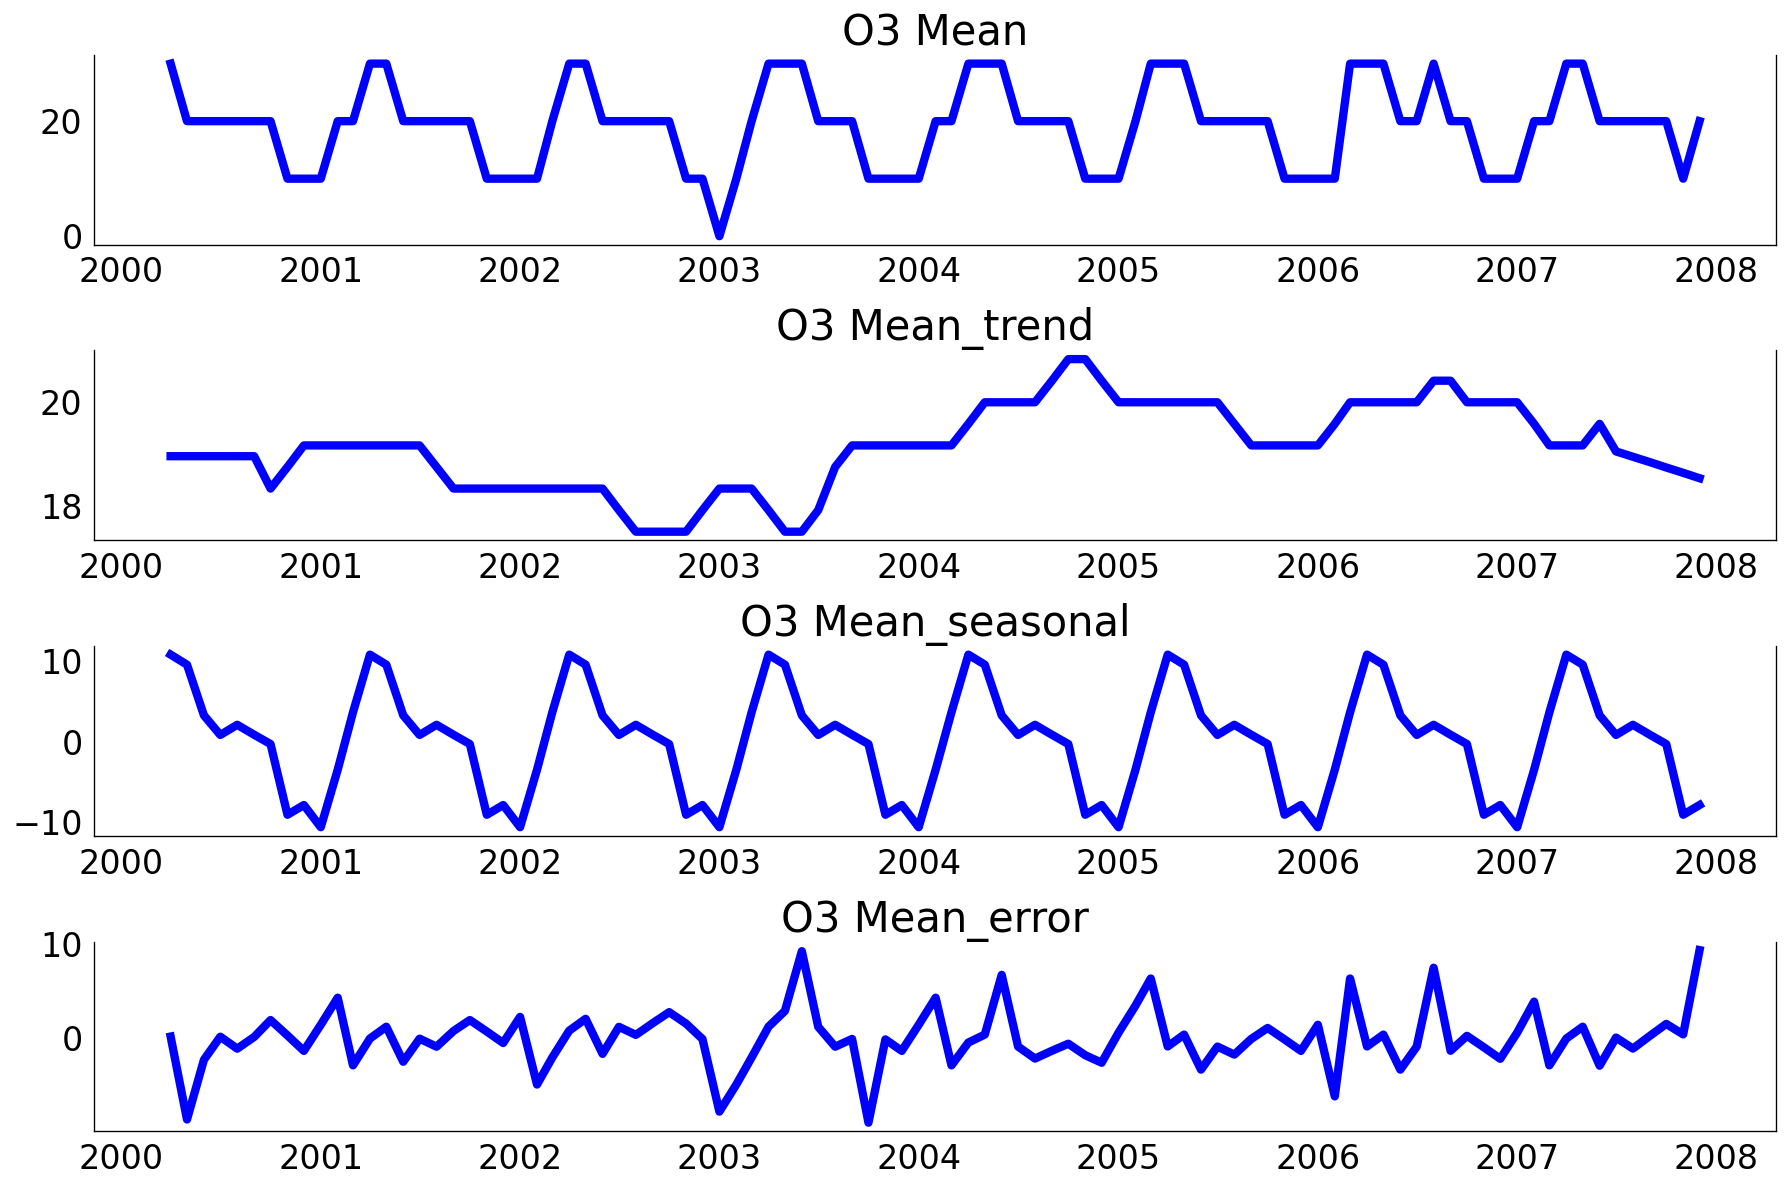

In [74]:
# Plot decomposition
o3_ets = ets_train_data[['O3 Mean', 'O3 Mean_trend', 'O3 Mean_seasonal', 'O3 Mean_error']]

fig, axes = plt.subplots(nrows=4, ncols=1, dpi=120, figsize=(15,10))
for i, ax in enumerate(axes.flatten()):
    data = o3_ets[o3_ets.columns[i]]
    ax.plot(data, color='blue', linewidth=5)
    # Decorations
    ax.set_title(o3_ets.columns[i], fontsize=25)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=20)

plt.tight_layout();

In [75]:
ets_train_data.head()

,O3 Mean,SO2 Mean,O3 AQI,O3 Mean_lag-1,SO2 Mean_lag-1,O3 AQI_lag-1,O3 Mean_lag-2,SO2 Mean_lag-2,O3 AQI_lag-2,O3 Mean_lag-3,...,O3 AQI_lag-3,O3 Mean_trend,O3 Mean_seasonal,O3 Mean_error,SO2 Mean_trend,SO2 Mean_seasonal,SO2 Mean_error,O3 AQI_trend,O3 AQI_seasonal,O3 AQI_error
Date Local,,,,,,,,,,,,,,,,,,,,,
2000-04-01,30.0,1.64,28.43,20.0,1.86,24.71,20.0,2.00,20.97,10.0,...,13.65,18.958333,10.844019,0.197647,3.305594,-0.460114,-1.205481,18.256698,9.127130,1.046172
2000-05-01,20.0,1.72,26.00,30.0,1.64,28.43,20.0,1.86,24.71,20.0,...,20.97,18.958333,9.594019,-8.552353,3.227354,-0.625282,-0.882073,18.450022,7.289735,0.260243
2000-06-01,20.0,1.85,22.55,20.0,1.72,26.00,30.0,1.64,28.43,20.0,...,24.71,18.958333,3.291936,-2.250269,3.149114,-0.746595,-0.552519,18.643347,1.956507,1.950146
2000-07-01,20.0,1.75,16.06,20.0,1.85,22.55,20.0,1.72,26.00,30.0,...,28.43,18.958333,0.858527,0.183139,3.070874,-0.741141,-0.579733,18.836672,-3.140821,0.364149
2000-08-01,20.0,2.06,17.48,20.0,1.75,16.06,20.0,1.85,22.55,20.0,...,26.00,18.958333,2.121457,-1.079790,2.992634,-0.553549,-0.379085,19.029996,-0.935273,-0.614723


In [76]:
# add dummy variables for quarter

ets_train_data['Quarter'] = ets_train_data.index.quarter
# display the dataframe
ets_train_data

,O3 Mean,SO2 Mean,O3 AQI,O3 Mean_lag-1,SO2 Mean_lag-1,O3 AQI_lag-1,O3 Mean_lag-2,SO2 Mean_lag-2,O3 AQI_lag-2,O3 Mean_lag-3,...,O3 Mean_trend,O3 Mean_seasonal,O3 Mean_error,SO2 Mean_trend,SO2 Mean_seasonal,SO2 Mean_error,O3 AQI_trend,O3 AQI_seasonal,O3 AQI_error,Quarter
Date Local,,,,,,,,,,,,,,,,,,,,,
2000-04-01,30.0,1.64,28.43,20.0,1.86,24.71,20.0,2.00,20.97,10.0,...,18.958333,10.844019,0.197647,3.305594,-0.460114,-1.205481,18.256698,9.127130,1.046172,2
2000-05-01,20.0,1.72,26.00,30.0,1.64,28.43,20.0,1.86,24.71,20.0,...,18.958333,9.594019,-8.552353,3.227354,-0.625282,-0.882073,18.450022,7.289735,0.260243,2
2000-06-01,20.0,1.85,22.55,20.0,1.72,26.00,30.0,1.64,28.43,20.0,...,18.958333,3.291936,-2.250269,3.149114,-0.746595,-0.552519,18.643347,1.956507,1.950146,2
2000-07-01,20.0,1.75,16.06,20.0,1.85,22.55,20.0,1.72,26.00,30.0,...,18.958333,0.858527,0.183139,3.070874,-0.741141,-0.579733,18.836672,-3.140821,0.364149,3
2000-08-01,20.0,2.06,17.48,20.0,1.75,16.06,20.0,1.85,22.55,20.0,...,18.958333,2.121457,-1.079790,2.992634,-0.553549,-0.379085,19.029996,-0.935273,-0.614723,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-08-01,20.0,0.73,20.81,20.0,0.12,17.33,20.0,0.24,22.33,30.0,...,18.947164,2.121457,-1.068621,0.994189,-0.553549,0.289360,22.344261,-0.935273,-0.598988,3
2007-09-01,20.0,1.05,25.87,20.0,0.73,20.81,20.0,0.12,17.33,20.0,...,18.843726,0.884387,0.271887,0.973771,-0.350383,0.426612,22.249889,2.046472,1.573639,3
2007-10-01,20.0,1.29,22.68,20.0,1.05,25.87,20.0,0.73,20.81,20.0,...,18.740287,-0.274558,1.534271,0.953353,0.076260,0.260387,22.155517,0.407590,0.116893,4


Dummy variables in regression - https://stattrek.com/multiple-regression/dummy-variables

In [77]:
# create dummy variables for the Quarter column - one hot encoding

ets_train_data = pd.get_dummies(ets_train_data, columns=['Quarter'], drop_first=True)

In [78]:
ets_train_data

,O3 Mean,SO2 Mean,O3 AQI,O3 Mean_lag-1,SO2 Mean_lag-1,O3 AQI_lag-1,O3 Mean_lag-2,SO2 Mean_lag-2,O3 AQI_lag-2,O3 Mean_lag-3,...,O3 Mean_error,SO2 Mean_trend,SO2 Mean_seasonal,SO2 Mean_error,O3 AQI_trend,O3 AQI_seasonal,O3 AQI_error,Quarter_2,Quarter_3,Quarter_4
Date Local,,,,,,,,,,,,,,,,,,,,,
2000-04-01,30.0,1.64,28.43,20.0,1.86,24.71,20.0,2.00,20.97,10.0,...,0.197647,3.305594,-0.460114,-1.205481,18.256698,9.127130,1.046172,1,0,0
2000-05-01,20.0,1.72,26.00,30.0,1.64,28.43,20.0,1.86,24.71,20.0,...,-8.552353,3.227354,-0.625282,-0.882073,18.450022,7.289735,0.260243,1,0,0
2000-06-01,20.0,1.85,22.55,20.0,1.72,26.00,30.0,1.64,28.43,20.0,...,-2.250269,3.149114,-0.746595,-0.552519,18.643347,1.956507,1.950146,1,0,0
2000-07-01,20.0,1.75,16.06,20.0,1.85,22.55,20.0,1.72,26.00,30.0,...,0.183139,3.070874,-0.741141,-0.579733,18.836672,-3.140821,0.364149,0,1,0
2000-08-01,20.0,2.06,17.48,20.0,1.75,16.06,20.0,1.85,22.55,20.0,...,-1.079790,2.992634,-0.553549,-0.379085,19.029996,-0.935273,-0.614723,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-08-01,20.0,0.73,20.81,20.0,0.12,17.33,20.0,0.24,22.33,30.0,...,-1.068621,0.994189,-0.553549,0.289360,22.344261,-0.935273,-0.598988,0,1,0
2007-09-01,20.0,1.05,25.87,20.0,0.73,20.81,20.0,0.12,17.33,20.0,...,0.271887,0.973771,-0.350383,0.426612,22.249889,2.046472,1.573639,0,1,0
2007-10-01,20.0,1.29,22.68,20.0,1.05,25.87,20.0,0.73,20.81,20.0,...,1.534271,0.953353,0.076260,0.260387,22.155517,0.407590,0.116893,0,0,1


All the transformation are done. Let us come back to the question -

##### Q1. What are the leading indicators that explain the average Ozone Air Quality Index over the next 12 months?

To answer this, we will have to create our Dependent or Predicted variable which is the average O3 AQI for the next 12 months


In [79]:
# Create new column for average O3 AQI for the next 12 months

In [80]:
ets_train_data['avg_o3_aqi_next_12'] = ets_train_data['O3 AQI'].rolling(12).mean().shift(-12)

In [81]:
ets_train_data

,O3 Mean,SO2 Mean,O3 AQI,O3 Mean_lag-1,SO2 Mean_lag-1,O3 AQI_lag-1,O3 Mean_lag-2,SO2 Mean_lag-2,O3 AQI_lag-2,O3 Mean_lag-3,...,SO2 Mean_trend,SO2 Mean_seasonal,SO2 Mean_error,O3 AQI_trend,O3 AQI_seasonal,O3 AQI_error,Quarter_2,Quarter_3,Quarter_4,avg_o3_aqi_next_12
Date Local,,,,,,,,,,,,,,,,,,,,,
2000-04-01,30.0,1.64,28.43,20.0,1.86,24.71,20.0,2.00,20.97,10.0,...,3.305594,-0.460114,-1.205481,18.256698,9.127130,1.046172,1,0,0,19.592500
2000-05-01,20.0,1.72,26.00,30.0,1.64,28.43,20.0,1.86,24.71,20.0,...,3.227354,-0.625282,-0.882073,18.450022,7.289735,0.260243,1,0,0,19.893333
2000-06-01,20.0,1.85,22.55,20.0,1.72,26.00,30.0,1.64,28.43,20.0,...,3.149114,-0.746595,-0.552519,18.643347,1.956507,1.950146,1,0,0,19.847500
2000-07-01,20.0,1.75,16.06,20.0,1.85,22.55,20.0,1.72,26.00,30.0,...,3.070874,-0.741141,-0.579733,18.836672,-3.140821,0.364149,0,1,0,20.127500
2000-08-01,20.0,2.06,17.48,20.0,1.75,16.06,20.0,1.85,22.55,20.0,...,2.992634,-0.553549,-0.379085,19.029996,-0.935273,-0.614723,0,1,0,20.127500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-08-01,20.0,0.73,20.81,20.0,0.12,17.33,20.0,0.24,22.33,30.0,...,0.994189,-0.553549,0.289360,22.344261,-0.935273,-0.598988,0,1,0,NaN
2007-09-01,20.0,1.05,25.87,20.0,0.73,20.81,20.0,0.12,17.33,20.0,...,0.973771,-0.350383,0.426612,22.249889,2.046472,1.573639,0,1,0,NaN
2007-10-01,20.0,1.29,22.68,20.0,1.05,25.87,20.0,0.73,20.81,20.0,...,0.953353,0.076260,0.260387,22.155517,0.407590,0.116893,0,0,1,NaN


In [82]:
ets_train_data.tail(14)

,O3 Mean,SO2 Mean,O3 AQI,O3 Mean_lag-1,SO2 Mean_lag-1,O3 AQI_lag-1,O3 Mean_lag-2,SO2 Mean_lag-2,O3 AQI_lag-2,O3 Mean_lag-3,...,SO2 Mean_trend,SO2 Mean_seasonal,SO2 Mean_error,O3 AQI_trend,O3 AQI_seasonal,O3 AQI_error,Quarter_2,Quarter_3,Quarter_4,avg_o3_aqi_next_12
Date Local,,,,,,,,,,,,,,,,,,,,,
2006-11-01,10.0,1.71,17.43,20.0,1.70,25.71,20.0,0.77,26.33,30.0,...,1.151250,0.642771,-0.084021,23.362500,-5.480249,-0.452251,0,0,1,22.485000
2006-12-01,10.0,2.90,14.74,10.0,1.71,17.43,20.0,1.70,25.71,20.0,...,1.120000,0.951052,0.828948,23.379583,-6.515900,-2.123683,0,0,1,22.918333
2007-01-01,10.0,2.19,15.97,10.0,2.90,14.74,10.0,1.71,17.43,20.0,...,1.092917,1.070005,0.027078,23.180417,-8.426869,1.216453,0,0,0,NaN
2007-02-01,20.0,0.87,23.68,10.0,2.19,15.97,10.0,2.90,14.74,10.0,...,1.086667,0.596196,-0.812862,22.920000,-1.338536,2.098536,0,0,0,NaN
2007-03-01,20.0,1.06,26.32,20.0,0.87,23.68,10.0,2.19,15.97,10.0,...,1.112500,0.140779,-0.193279,22.745000,5.010214,-1.435214,0,0,0,NaN
2007-04-01,30.0,0.61,30.07,20.0,1.06,26.32,20.0,0.87,23.68,10.0,...,1.107083,-0.460114,-0.036970,22.599583,9.127130,-1.656713,1,0,0,NaN
2007-05-01,30.0,0.31,32.45,30.0,0.61,30.07,20.0,1.06,26.32,20.0,...,1.103750,-0.625282,-0.168468,22.479167,7.289735,2.681098,1,0,0,NaN
2007-06-01,20.0,0.24,22.33,30.0,0.31,32.45,30.0,0.61,30.07,20.0,...,1.076250,-0.746595,-0.089655,22.701667,1.956507,-2.328174,1,0,0,NaN
2007-07-01,20.0,0.12,17.33,20.0,0.24,22.33,30.0,0.31,32.45,30.0,...,1.014607,-0.741141,-0.153466,22.438633,-3.140821,-1.967812,0,1,0,NaN


In [83]:
ets_train_data = ets_train_data.dropna()
ets_train_data

,O3 Mean,SO2 Mean,O3 AQI,O3 Mean_lag-1,SO2 Mean_lag-1,O3 AQI_lag-1,O3 Mean_lag-2,SO2 Mean_lag-2,O3 AQI_lag-2,O3 Mean_lag-3,...,SO2 Mean_trend,SO2 Mean_seasonal,SO2 Mean_error,O3 AQI_trend,O3 AQI_seasonal,O3 AQI_error,Quarter_2,Quarter_3,Quarter_4,avg_o3_aqi_next_12
Date Local,,,,,,,,,,,,,,,,,,,,,
2000-04-01,30.0,1.64,28.43,20.0,1.86,24.71,20.0,2.00,20.97,10.0,...,3.305594,-0.460114,-1.205481,18.256698,9.127130,1.046172,1,0,0,19.592500
2000-05-01,20.0,1.72,26.00,30.0,1.64,28.43,20.0,1.86,24.71,20.0,...,3.227354,-0.625282,-0.882073,18.450022,7.289735,0.260243,1,0,0,19.893333
2000-06-01,20.0,1.85,22.55,20.0,1.72,26.00,30.0,1.64,28.43,20.0,...,3.149114,-0.746595,-0.552519,18.643347,1.956507,1.950146,1,0,0,19.847500
2000-07-01,20.0,1.75,16.06,20.0,1.85,22.55,20.0,1.72,26.00,30.0,...,3.070874,-0.741141,-0.579733,18.836672,-3.140821,0.364149,0,1,0,20.127500
2000-08-01,20.0,2.06,17.48,20.0,1.75,16.06,20.0,1.85,22.55,20.0,...,2.992634,-0.553549,-0.379085,19.029996,-0.935273,-0.614723,0,1,0,20.127500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-08-01,30.0,0.39,24.55,20.0,0.61,19.84,20.0,0.40,24.60,30.0,...,1.240833,-0.553549,-0.297285,23.436250,-0.935273,2.049023,0,1,0,22.764167
2006-09-01,20.0,0.77,26.33,30.0,0.39,24.55,20.0,0.61,19.84,20.0,...,1.190000,-0.350383,-0.069617,23.395000,2.046472,0.888528,0,1,0,22.725833
2006-10-01,20.0,1.70,25.71,20.0,0.77,26.33,30.0,0.39,24.55,20.0,...,1.186250,0.076260,0.437490,23.245000,0.407590,2.057410,0,0,1,22.473333


In [84]:
ets_train_data.columns

Index(['O3 Mean', 'SO2 Mean', 'O3 AQI', 'O3 Mean_lag-1', 'SO2 Mean_lag-1',
       'O3 AQI_lag-1', 'O3 Mean_lag-2', 'SO2 Mean_lag-2', 'O3 AQI_lag-2',
       'O3 Mean_lag-3', 'SO2 Mean_lag-3', 'O3 AQI_lag-3', 'O3 Mean_trend',
       'O3 Mean_seasonal', 'O3 Mean_error', 'SO2 Mean_trend',
       'SO2 Mean_seasonal', 'SO2 Mean_error', 'O3 AQI_trend',
       'O3 AQI_seasonal', 'O3 AQI_error', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'avg_o3_aqi_next_12'],
      dtype='object')

Final data preparations before answering the question -
delete the true means of o3, so2, and o3 aqi because the information is contained in their E, T, and S columns combined.

In [85]:
ets_train_data = ets_train_data.drop(['O3 Mean', 'SO2 Mean', 'O3 AQI'], axis = 1)
ets_train_data

,O3 Mean_lag-1,SO2 Mean_lag-1,O3 AQI_lag-1,O3 Mean_lag-2,SO2 Mean_lag-2,O3 AQI_lag-2,O3 Mean_lag-3,SO2 Mean_lag-3,O3 AQI_lag-3,O3 Mean_trend,...,SO2 Mean_trend,SO2 Mean_seasonal,SO2 Mean_error,O3 AQI_trend,O3 AQI_seasonal,O3 AQI_error,Quarter_2,Quarter_3,Quarter_4,avg_o3_aqi_next_12
Date Local,,,,,,,,,,,,,,,,,,,,,
2000-04-01,20.0,1.86,24.71,20.0,2.00,20.97,10.0,2.77,13.65,18.958333,...,3.305594,-0.460114,-1.205481,18.256698,9.127130,1.046172,1,0,0,19.592500
2000-05-01,30.0,1.64,28.43,20.0,1.86,24.71,20.0,2.00,20.97,18.958333,...,3.227354,-0.625282,-0.882073,18.450022,7.289735,0.260243,1,0,0,19.893333
2000-06-01,20.0,1.72,26.00,30.0,1.64,28.43,20.0,1.86,24.71,18.958333,...,3.149114,-0.746595,-0.552519,18.643347,1.956507,1.950146,1,0,0,19.847500
2000-07-01,20.0,1.85,22.55,20.0,1.72,26.00,30.0,1.64,28.43,18.958333,...,3.070874,-0.741141,-0.579733,18.836672,-3.140821,0.364149,0,1,0,20.127500
2000-08-01,20.0,1.75,16.06,20.0,1.85,22.55,20.0,1.72,26.00,18.958333,...,2.992634,-0.553549,-0.379085,19.029996,-0.935273,-0.614723,0,1,0,20.127500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-08-01,20.0,0.61,19.84,20.0,0.40,24.60,30.0,0.90,29.77,20.416667,...,1.240833,-0.553549,-0.297285,23.436250,-0.935273,2.049023,0,1,0,22.764167
2006-09-01,30.0,0.39,24.55,20.0,0.61,19.84,20.0,0.40,24.60,20.416667,...,1.190000,-0.350383,-0.069617,23.395000,2.046472,0.888528,0,1,0,22.725833
2006-10-01,20.0,0.77,26.33,30.0,0.39,24.55,20.0,0.61,19.84,20.000000,...,1.186250,0.076260,0.437490,23.245000,0.407590,2.057410,0,0,1,22.473333


In [86]:
ets_train_data.columns

Index(['O3 Mean_lag-1', 'SO2 Mean_lag-1', 'O3 AQI_lag-1', 'O3 Mean_lag-2',
       'SO2 Mean_lag-2', 'O3 AQI_lag-2', 'O3 Mean_lag-3', 'SO2 Mean_lag-3',
       'O3 AQI_lag-3', 'O3 Mean_trend', 'O3 Mean_seasonal', 'O3 Mean_error',
       'SO2 Mean_trend', 'SO2 Mean_seasonal', 'SO2 Mean_error', 'O3 AQI_trend',
       'O3 AQI_seasonal', 'O3 AQI_error', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'avg_o3_aqi_next_12'],
      dtype='object')

## Variable Importance and Model Explainability (XAI)

In [87]:
#source: To lean about SHAP which is one of the most widely used XAI techniques, go to the following link
# https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137#:~:text=SHAP%20values%20(SHapley%20Additive%20exPlanations,interpretability%20of%20machine%20learning%20models.

In [88]:
ets_train_data

,O3 Mean_lag-1,SO2 Mean_lag-1,O3 AQI_lag-1,O3 Mean_lag-2,SO2 Mean_lag-2,O3 AQI_lag-2,O3 Mean_lag-3,SO2 Mean_lag-3,O3 AQI_lag-3,O3 Mean_trend,...,SO2 Mean_trend,SO2 Mean_seasonal,SO2 Mean_error,O3 AQI_trend,O3 AQI_seasonal,O3 AQI_error,Quarter_2,Quarter_3,Quarter_4,avg_o3_aqi_next_12
Date Local,,,,,,,,,,,,,,,,,,,,,
2000-04-01,20.0,1.86,24.71,20.0,2.00,20.97,10.0,2.77,13.65,18.958333,...,3.305594,-0.460114,-1.205481,18.256698,9.127130,1.046172,1,0,0,19.592500
2000-05-01,30.0,1.64,28.43,20.0,1.86,24.71,20.0,2.00,20.97,18.958333,...,3.227354,-0.625282,-0.882073,18.450022,7.289735,0.260243,1,0,0,19.893333
2000-06-01,20.0,1.72,26.00,30.0,1.64,28.43,20.0,1.86,24.71,18.958333,...,3.149114,-0.746595,-0.552519,18.643347,1.956507,1.950146,1,0,0,19.847500
2000-07-01,20.0,1.85,22.55,20.0,1.72,26.00,30.0,1.64,28.43,18.958333,...,3.070874,-0.741141,-0.579733,18.836672,-3.140821,0.364149,0,1,0,20.127500
2000-08-01,20.0,1.75,16.06,20.0,1.85,22.55,20.0,1.72,26.00,18.958333,...,2.992634,-0.553549,-0.379085,19.029996,-0.935273,-0.614723,0,1,0,20.127500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-08-01,20.0,0.61,19.84,20.0,0.40,24.60,30.0,0.90,29.77,20.416667,...,1.240833,-0.553549,-0.297285,23.436250,-0.935273,2.049023,0,1,0,22.764167
2006-09-01,30.0,0.39,24.55,20.0,0.61,19.84,20.0,0.40,24.60,20.416667,...,1.190000,-0.350383,-0.069617,23.395000,2.046472,0.888528,0,1,0,22.725833
2006-10-01,20.0,0.77,26.33,30.0,0.39,24.55,20.0,0.61,19.84,20.000000,...,1.186250,0.076260,0.437490,23.245000,0.407590,2.057410,0,0,1,22.473333


In [89]:
# create X and y datasets - independent and dependent variables
X = ets_train_data.copy().drop(['avg_o3_aqi_next_12'], axis = 1)
y = ets_train_data.copy().avg_o3_aqi_next_12

In [90]:
X

,O3 Mean_lag-1,SO2 Mean_lag-1,O3 AQI_lag-1,O3 Mean_lag-2,SO2 Mean_lag-2,O3 AQI_lag-2,O3 Mean_lag-3,SO2 Mean_lag-3,O3 AQI_lag-3,O3 Mean_trend,...,O3 Mean_error,SO2 Mean_trend,SO2 Mean_seasonal,SO2 Mean_error,O3 AQI_trend,O3 AQI_seasonal,O3 AQI_error,Quarter_2,Quarter_3,Quarter_4
Date Local,,,,,,,,,,,,,,,,,,,,,
2000-04-01,20.0,1.86,24.71,20.0,2.00,20.97,10.0,2.77,13.65,18.958333,...,0.197647,3.305594,-0.460114,-1.205481,18.256698,9.127130,1.046172,1,0,0
2000-05-01,30.0,1.64,28.43,20.0,1.86,24.71,20.0,2.00,20.97,18.958333,...,-8.552353,3.227354,-0.625282,-0.882073,18.450022,7.289735,0.260243,1,0,0
2000-06-01,20.0,1.72,26.00,30.0,1.64,28.43,20.0,1.86,24.71,18.958333,...,-2.250269,3.149114,-0.746595,-0.552519,18.643347,1.956507,1.950146,1,0,0
2000-07-01,20.0,1.85,22.55,20.0,1.72,26.00,30.0,1.64,28.43,18.958333,...,0.183139,3.070874,-0.741141,-0.579733,18.836672,-3.140821,0.364149,0,1,0
2000-08-01,20.0,1.75,16.06,20.0,1.85,22.55,20.0,1.72,26.00,18.958333,...,-1.079790,2.992634,-0.553549,-0.379085,19.029996,-0.935273,-0.614723,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-08-01,20.0,0.61,19.84,20.0,0.40,24.60,30.0,0.90,29.77,20.416667,...,7.461876,1.240833,-0.553549,-0.297285,23.436250,-0.935273,2.049023,0,1,0
2006-09-01,30.0,0.39,24.55,20.0,0.61,19.84,20.0,0.40,24.60,20.416667,...,-1.301054,1.190000,-0.350383,-0.069617,23.395000,2.046472,0.888528,0,1,0
2006-10-01,20.0,0.77,26.33,30.0,0.39,24.55,20.0,0.61,19.84,20.000000,...,0.274558,1.186250,0.076260,0.437490,23.245000,0.407590,2.057410,0,0,1


In [91]:
y

Date Local
2000-04-01    19.592500
2000-05-01    19.893333
2000-06-01    19.847500
2000-07-01    20.127500
2000-08-01    20.127500
                ...    
2006-08-01    22.764167
2006-09-01    22.725833
2006-10-01    22.473333
2006-11-01    22.485000
2006-12-01    22.918333
Freq: MS, Name: avg_o3_aqi_next_12, Length: 81, dtype: float64

In [92]:
# let us use a random forest regressor to model the relationship between the independent and dependent variables

In [93]:
# Prepares a default instance of the random forest regressor
forest = RandomForestRegressor(random_state=10, n_estimators=30)
# Fits the model on the data
forest.fit(X, y)

RandomForestRegressor(n_estimators=30, random_state=10)

In [94]:
# Feature importances are provided by the fitted attribute feature_importances_ and they
# are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

# Source: https://mljar.com/blog/feature-importance-in-random-forest/

In [95]:
forest.feature_importances_

array([1.23807621e-03, 8.24699406e-03, 5.59148001e-03, 9.06724153e-04,
       1.27165682e-02, 4.45223097e-03, 3.54663466e-04, 1.06900713e-02,
       7.06062893e-03, 3.76875539e-02, 4.50635680e-03, 9.51029299e-03,
       2.63455384e-01, 4.43321303e-03, 8.03584069e-03, 5.98492823e-01,
       5.57693095e-03, 1.41183685e-02, 2.97043801e-04, 1.81914985e-03,
       8.09605903e-04])

In [96]:
train_data

,O3 Mean,SO2 Mean,O3 AQI
Date Local,,,
2000-01-01,10.0,2.77,13.65
2000-02-01,20.0,2.00,20.97
2000-03-01,20.0,1.86,24.71
2000-04-01,30.0,1.64,28.43
2000-05-01,20.0,1.72,26.00
...,...,...,...
2007-08-01,20.0,0.73,20.81
2007-09-01,20.0,1.05,25.87
2007-10-01,20.0,1.29,22.68


##### Q1. What are the leading indicators that explain the average Ozone Air Quality Index over the next 12 months?

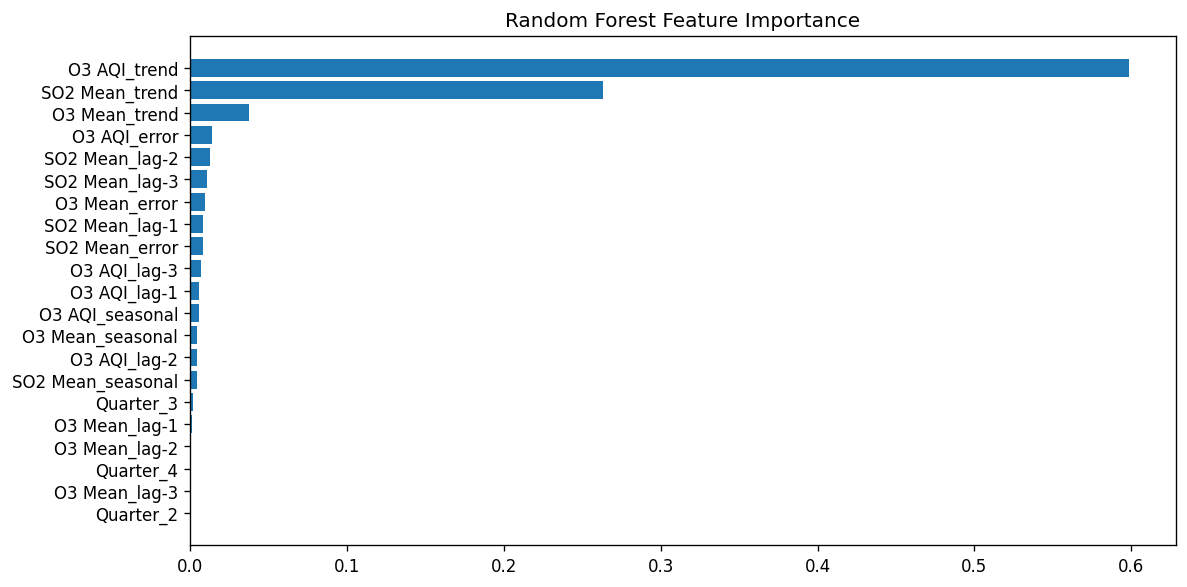

In [97]:
# plot feature importance

plt.figure(dpi=120, figsize=(10,5))
sorted_idx = forest.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], forest.feature_importances_[sorted_idx])
plt.title("Random Forest Feature Importance")
plt.tight_layout();

Q1. What are the leading indicators that explain what the average Ozone Air Quality Index will be over the next 12 months?

Answers?

In [98]:
#shap for explaining models - https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454

### Q2. Predict monthly average Ozone Air Quality Index for each of the next 12 months.

#### Multioutput Regression

Many machine learning algorithms are designed for predicting a single numeric value, referred to simply as regression. Regression refers to a predictive modeling problem that involves predicting a numerical value such as size, weight, amount, number of sales, and number of clicks.

But, some regression problems require the prediction of two or more numeric values and these are 'Multioutput Regression' problems.

Examples of multiouput regression -
1. Predict a coordinate given an input, e.g. predicting x and y values.
2. Multi-step time series forecasting that involves predicting multiple future time series of a given variable.

Some algorithms do support multioutput regression inherently, such as
1. linear regression
2. decision trees
3. random forest
4. kneighbors

But, not all regression algorithms support multioutput regression. A workaround for using regression models designed for predicting one value for multioutput regression is to divide the multioutput regression problem into multiple sub-problems. The most obvious way to do this is to split a multioutput regression problem into multiple single-output regression problems.

There are two main approaches to implementing this technique.

A. The 'Direct Multioutput' approach involves developing a separate regression model for each output value to be predicted. We can think of this as a direct approach, as each target value is modeled directly. For example, if a multioutput regression problem required the prediction of three values y1, y2, and y3 given an input X, then this could be partitioned into three single-output regression problems such as follows.

1. Problem 1: Given X, predict y1
2. Problem 2: Given X, predict y2
3. Problem 3: Given X, predict y3.


B. The 'Chained Multioutput' approach is an extension of the first method except the models are organized into a chain. The prediction from the first model is taken as part of the input to the second model, and the process of output-to-input dependency repeats along the chain of models. This approach to using single-output regression models for multioutput regression is to create a linear sequence of models.

The first model in the sequence uses the input and predicts one output; the second model uses the input and the output from the first model to make a prediction; the third model uses the input and output from the first two models to make a prediction, and so on.

For example, if a multioutput regression problem required the prediction of three values y1, y2 and y3 given an input X, then this could be partitioned into three dependent single-output regression problems as follows:

1. Problem 1: Given X, predict y1
2. Problem 2: Given X and yhat1, predict y2
3. Problem 3: Given X, yhat1, and yhat2, predict y3.

Let’s take a closer look at each of these techniques below.

Source: https://machinelearningmastery.com/multi-output-regression-models-with-python/

In [99]:
# let's take a look at the train_data again and use it to create multistep forecasts
train_data

,O3 Mean,SO2 Mean,O3 AQI
Date Local,,,
2000-01-01,10.0,2.77,13.65
2000-02-01,20.0,2.00,20.97
2000-03-01,20.0,1.86,24.71
2000-04-01,30.0,1.64,28.43
2000-05-01,20.0,1.72,26.00
...,...,...,...
2007-08-01,20.0,0.73,20.81
2007-09-01,20.0,1.05,25.87
2007-10-01,20.0,1.29,22.68


In the last section we used dummy variables to capture Quarterly information. In this section let us see how can we use 'Cyclical Encoding'. Many features commonly found in datasets are cyclical in nature. The best example of such a feature is of course time: months, days, weekdays, hours, minutes, seconds etc. are all cyclical in nature. Other examples include features such as seasons, tidal and astrological data.

The challenge is letting the machine learning algorithms know that features such as these occur in cycles.

Source: https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning/notebook

In [100]:
#create a new dataset by copying train_data
mutistep_df = train_data.copy()

#create date features to cyclicaly encode month and quarter
mutistep_df['Year'] = train_data.index.year
mutistep_df['Month'] =  train_data.index.month
mutistep_df['Quarter'] =  train_data.index.quarter
mutistep_df

,O3 Mean,SO2 Mean,O3 AQI,Year,Month,Quarter
Date Local,,,,,,
2000-01-01,10.0,2.77,13.65,2000,1,1
2000-02-01,20.0,2.00,20.97,2000,2,1
2000-03-01,20.0,1.86,24.71,2000,3,1
2000-04-01,30.0,1.64,28.43,2000,4,2
2000-05-01,20.0,1.72,26.00,2000,5,2
...,...,...,...,...,...,...
2007-08-01,20.0,0.73,20.81,2007,8,3
2007-09-01,20.0,1.05,25.87,2007,9,3
2007-10-01,20.0,1.29,22.68,2007,10,4


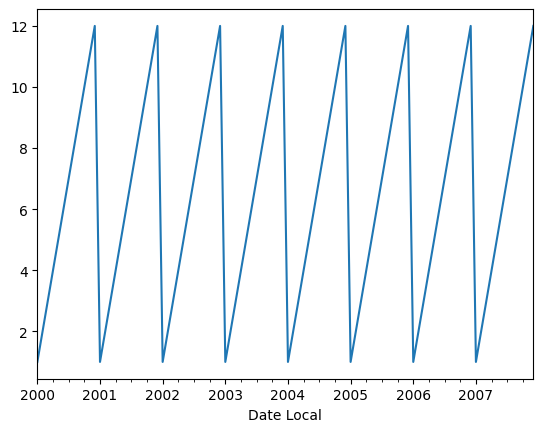

In [101]:
ax = mutistep_df['Month'].plot()


This graph illustrates the problem with presenting cyclical data to a machine learning algorithm. There are jump discontinuities in the graph at the end of each month, when the month value goes from  12  to  01.

Even though Dec 2000 and Jan 2001 are just one month apart, on the graph it seems like they are 11 months apart. Hence, cyclical encoding. A common method for encoding cyclical data is to transform the data into two dimensions using a sine and consine transformation.

We can do that using the following transformations:
1. xsin=sin(2∗π∗x/max(x))
2. xcos=cos(2∗π∗x/max(x))

Let's do this for our monthly data.

In [102]:
#radially/cyclically encode month and quarter

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

mutistep_df = encode(mutistep_df, 'Month', 12)
mutistep_df = encode(mutistep_df, 'Quarter', 4)

In [103]:
mutistep_df

,O3 Mean,SO2 Mean,O3 AQI,Year,Month,Quarter,Month_sin,Month_cos,Quarter_sin,Quarter_cos
Date Local,,,,,,,,,,
2000-01-01,10.0,2.77,13.65,2000,1,1,5.000000e-01,8.660254e-01,1.000000e+00,6.123234e-17
2000-02-01,20.0,2.00,20.97,2000,2,1,8.660254e-01,5.000000e-01,1.000000e+00,6.123234e-17
2000-03-01,20.0,1.86,24.71,2000,3,1,1.000000e+00,6.123234e-17,1.000000e+00,6.123234e-17
2000-04-01,30.0,1.64,28.43,2000,4,2,8.660254e-01,-5.000000e-01,1.224647e-16,-1.000000e+00
2000-05-01,20.0,1.72,26.00,2000,5,2,5.000000e-01,-8.660254e-01,1.224647e-16,-1.000000e+00
...,...,...,...,...,...,...,...,...,...,...
2007-08-01,20.0,0.73,20.81,2007,8,3,-8.660254e-01,-5.000000e-01,-1.000000e+00,-1.836970e-16
2007-09-01,20.0,1.05,25.87,2007,9,3,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16
2007-10-01,20.0,1.29,22.68,2007,10,4,-8.660254e-01,5.000000e-01,-2.449294e-16,1.000000e+00


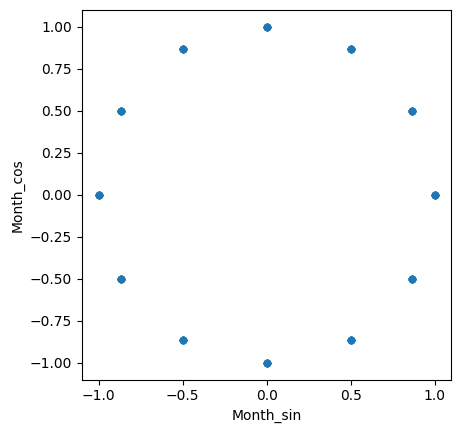

In [104]:
#cyclically encoded months
ax = mutistep_df.plot.scatter('Month_sin', 'Month_cos').set_aspect('equal')

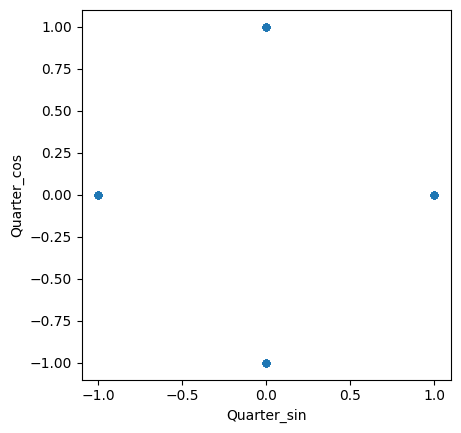

In [105]:
#cyclically encoded Quarters
ax = mutistep_df.plot.scatter('Quarter_sin', 'Quarter_cos').set_aspect('equal')

In [106]:
mutistep_df

,O3 Mean,SO2 Mean,O3 AQI,Year,Month,Quarter,Month_sin,Month_cos,Quarter_sin,Quarter_cos
Date Local,,,,,,,,,,
2000-01-01,10.0,2.77,13.65,2000,1,1,5.000000e-01,8.660254e-01,1.000000e+00,6.123234e-17
2000-02-01,20.0,2.00,20.97,2000,2,1,8.660254e-01,5.000000e-01,1.000000e+00,6.123234e-17
2000-03-01,20.0,1.86,24.71,2000,3,1,1.000000e+00,6.123234e-17,1.000000e+00,6.123234e-17
2000-04-01,30.0,1.64,28.43,2000,4,2,8.660254e-01,-5.000000e-01,1.224647e-16,-1.000000e+00
2000-05-01,20.0,1.72,26.00,2000,5,2,5.000000e-01,-8.660254e-01,1.224647e-16,-1.000000e+00
...,...,...,...,...,...,...,...,...,...,...
2007-08-01,20.0,0.73,20.81,2007,8,3,-8.660254e-01,-5.000000e-01,-1.000000e+00,-1.836970e-16
2007-09-01,20.0,1.05,25.87,2007,9,3,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16
2007-10-01,20.0,1.29,22.68,2007,10,4,-8.660254e-01,5.000000e-01,-2.449294e-16,1.000000e+00


In [107]:
# delete columns Month and Quarter
mutistep_df = mutistep_df.drop(['Month', 'Quarter'], axis = 1)
mutistep_df

,O3 Mean,SO2 Mean,O3 AQI,Year,Month_sin,Month_cos,Quarter_sin,Quarter_cos
Date Local,,,,,,,,
2000-01-01,10.0,2.77,13.65,2000,5.000000e-01,8.660254e-01,1.000000e+00,6.123234e-17
2000-02-01,20.0,2.00,20.97,2000,8.660254e-01,5.000000e-01,1.000000e+00,6.123234e-17
2000-03-01,20.0,1.86,24.71,2000,1.000000e+00,6.123234e-17,1.000000e+00,6.123234e-17
2000-04-01,30.0,1.64,28.43,2000,8.660254e-01,-5.000000e-01,1.224647e-16,-1.000000e+00
2000-05-01,20.0,1.72,26.00,2000,5.000000e-01,-8.660254e-01,1.224647e-16,-1.000000e+00
...,...,...,...,...,...,...,...,...
2007-08-01,20.0,0.73,20.81,2007,-8.660254e-01,-5.000000e-01,-1.000000e+00,-1.836970e-16
2007-09-01,20.0,1.05,25.87,2007,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16
2007-10-01,20.0,1.29,22.68,2007,-8.660254e-01,5.000000e-01,-2.449294e-16,1.000000e+00


In [108]:
# the aforementioned 'mutistep_df' will be used to create input and output sequences for modeling.
# but before that we  need to take a subset of the dataset to contain the last twelve months' information
# this to be fed into the model so as to forecast the next 12 months and compare with O3 AQI for 2008

#create the dataset (test) that contains the last 12 months' values
last_12months_data = mutistep_df.copy().tail(12)
last_12months_data

,O3 Mean,SO2 Mean,O3 AQI,Year,Month_sin,Month_cos,Quarter_sin,Quarter_cos
Date Local,,,,,,,,
2007-01-01,10.0,2.19,15.97,2007,5.000000e-01,8.660254e-01,1.000000e+00,6.123234e-17
2007-02-01,20.0,0.87,23.68,2007,8.660254e-01,5.000000e-01,1.000000e+00,6.123234e-17
2007-03-01,20.0,1.06,26.32,2007,1.000000e+00,6.123234e-17,1.000000e+00,6.123234e-17
2007-04-01,30.0,0.61,30.07,2007,8.660254e-01,-5.000000e-01,1.224647e-16,-1.000000e+00
2007-05-01,30.0,0.31,32.45,2007,5.000000e-01,-8.660254e-01,1.224647e-16,-1.000000e+00
2007-06-01,20.0,0.24,22.33,2007,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000e+00
2007-07-01,20.0,0.12,17.33,2007,-5.000000e-01,-8.660254e-01,-1.000000e+00,-1.836970e-16
2007-08-01,20.0,0.73,20.81,2007,-8.660254e-01,-5.000000e-01,-1.000000e+00,-1.836970e-16
2007-09-01,20.0,1.05,25.87,2007,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16


#### Create input and output sequences - show gsheet

In [109]:
# shift column O3 AQI to create a y label that is actuals shifted by 1 month
# this is going to be our target variable that we need to predict

mutistep_df['y'] = mutistep_df['O3 AQI'].shift(-1)

#get rid of NAs that will be created on the last row because of shifting the actuals
mutistep_df = mutistep_df.dropna()
mutistep_df

,O3 Mean,SO2 Mean,O3 AQI,Year,Month_sin,Month_cos,Quarter_sin,Quarter_cos,y
Date Local,,,,,,,,,
2000-01-01,10.0,2.77,13.65,2000,0.500000,8.660254e-01,1.000000e+00,6.123234e-17,20.97
2000-02-01,20.0,2.00,20.97,2000,0.866025,5.000000e-01,1.000000e+00,6.123234e-17,24.71
2000-03-01,20.0,1.86,24.71,2000,1.000000,6.123234e-17,1.000000e+00,6.123234e-17,28.43
2000-04-01,30.0,1.64,28.43,2000,0.866025,-5.000000e-01,1.224647e-16,-1.000000e+00,26.00
2000-05-01,20.0,1.72,26.00,2000,0.500000,-8.660254e-01,1.224647e-16,-1.000000e+00,22.55
...,...,...,...,...,...,...,...,...,...
2007-07-01,20.0,0.12,17.33,2007,-0.500000,-8.660254e-01,-1.000000e+00,-1.836970e-16,20.81
2007-08-01,20.0,0.73,20.81,2007,-0.866025,-5.000000e-01,-1.000000e+00,-1.836970e-16,25.87
2007-09-01,20.0,1.05,25.87,2007,-1.000000,-1.836970e-16,-1.000000e+00,-1.836970e-16,22.68


In [110]:
# ### Create input and output sequences (input is data from last 12 months to predict the next 12 months)

# multivariate multi-step data preparation

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps to look in the last to predict the number of time steps into the future
#look at 12 months in the past to predict the next 12 months
n_steps_in, n_steps_out = 12, 12

# convert into input/output
X_train, y_train = split_sequences(mutistep_df.values, n_steps_in, n_steps_out)

In [111]:
X_train

array([[[ 1.00000000e+01,  2.77000000e+00,  1.36500000e+01, ...,
          8.66025404e-01,  1.00000000e+00,  6.12323400e-17],
        [ 2.00000000e+01,  2.00000000e+00,  2.09700000e+01, ...,
          5.00000000e-01,  1.00000000e+00,  6.12323400e-17],
        [ 2.00000000e+01,  1.86000000e+00,  2.47100000e+01, ...,
          6.12323400e-17,  1.00000000e+00,  6.12323400e-17],
        ...,
        [ 2.00000000e+01,  2.41000000e+00,  2.16800000e+01, ...,
          5.00000000e-01, -2.44929360e-16,  1.00000000e+00],
        [ 1.00000000e+01,  3.33000000e+00,  1.21900000e+01, ...,
          8.66025404e-01, -2.44929360e-16,  1.00000000e+00],
        [ 1.00000000e+01,  4.25000000e+00,  9.42000000e+00, ...,
          1.00000000e+00, -2.44929360e-16,  1.00000000e+00]],

       [[ 2.00000000e+01,  2.00000000e+00,  2.09700000e+01, ...,
          5.00000000e-01,  1.00000000e+00,  6.12323400e-17],
        [ 2.00000000e+01,  1.86000000e+00,  2.47100000e+01, ...,
          6.12323400e-17,  1.00000000e

In [112]:
y_train

array([[13.65, 20.56, 24.23, 30.7 , 29.61, 22.  , 19.42, 17.48, 22.13,
        22.35, 17.5 , 18.52],
       [20.56, 24.23, 30.7 , 29.61, 22.  , 19.42, 17.48, 22.13, 22.35,
        17.5 , 18.52, 13.26],
       [24.23, 30.7 , 29.61, 22.  , 19.42, 17.48, 22.13, 22.35, 17.5 ,
        18.52, 13.26, 18.75],
       [30.7 , 29.61, 22.  , 19.42, 17.48, 22.13, 22.35, 17.5 , 18.52,
        13.26, 18.75, 28.1 ],
       [29.61, 22.  , 19.42, 17.48, 22.13, 22.35, 17.5 , 18.52, 13.26,
        18.75, 28.1 , 30.23],
       [22.  , 19.42, 17.48, 22.13, 22.35, 17.5 , 18.52, 13.26, 18.75,
        28.1 , 30.23, 30.54],
       [19.42, 17.48, 22.13, 22.35, 17.5 , 18.52, 13.26, 18.75, 28.1 ,
        30.23, 30.54, 23.83],
       [17.48, 22.13, 22.35, 17.5 , 18.52, 13.26, 18.75, 28.1 , 30.23,
        30.54, 23.83, 20.58],
       [22.13, 22.35, 17.5 , 18.52, 13.26, 18.75, 28.1 , 30.23, 30.54,
        23.83, 20.58, 24.66],
       [22.35, 17.5 , 18.52, 13.26, 18.75, 28.1 , 30.23, 30.54, 23.83,
        20.58, 24.66

In [113]:
X_train[0]

array([[ 1.00000000e+01,  2.77000000e+00,  1.36500000e+01,
         2.00000000e+03,  5.00000000e-01,  8.66025404e-01,
         1.00000000e+00,  6.12323400e-17],
       [ 2.00000000e+01,  2.00000000e+00,  2.09700000e+01,
         2.00000000e+03,  8.66025404e-01,  5.00000000e-01,
         1.00000000e+00,  6.12323400e-17],
       [ 2.00000000e+01,  1.86000000e+00,  2.47100000e+01,
         2.00000000e+03,  1.00000000e+00,  6.12323400e-17,
         1.00000000e+00,  6.12323400e-17],
       [ 3.00000000e+01,  1.64000000e+00,  2.84300000e+01,
         2.00000000e+03,  8.66025404e-01, -5.00000000e-01,
         1.22464680e-16, -1.00000000e+00],
       [ 2.00000000e+01,  1.72000000e+00,  2.60000000e+01,
         2.00000000e+03,  5.00000000e-01, -8.66025404e-01,
         1.22464680e-16, -1.00000000e+00],
       [ 2.00000000e+01,  1.85000000e+00,  2.25500000e+01,
         2.00000000e+03,  1.22464680e-16, -1.00000000e+00,
         1.22464680e-16, -1.00000000e+00],
       [ 2.00000000e+01,  1.750000

In [114]:
y_train[0]

array([13.65, 20.56, 24.23, 30.7 , 29.61, 22.  , 19.42, 17.48, 22.13,
       22.35, 17.5 , 18.52])

In [115]:
X_train[1]

array([[ 2.00000000e+01,  2.00000000e+00,  2.09700000e+01,
         2.00000000e+03,  8.66025404e-01,  5.00000000e-01,
         1.00000000e+00,  6.12323400e-17],
       [ 2.00000000e+01,  1.86000000e+00,  2.47100000e+01,
         2.00000000e+03,  1.00000000e+00,  6.12323400e-17,
         1.00000000e+00,  6.12323400e-17],
       [ 3.00000000e+01,  1.64000000e+00,  2.84300000e+01,
         2.00000000e+03,  8.66025404e-01, -5.00000000e-01,
         1.22464680e-16, -1.00000000e+00],
       [ 2.00000000e+01,  1.72000000e+00,  2.60000000e+01,
         2.00000000e+03,  5.00000000e-01, -8.66025404e-01,
         1.22464680e-16, -1.00000000e+00],
       [ 2.00000000e+01,  1.85000000e+00,  2.25500000e+01,
         2.00000000e+03,  1.22464680e-16, -1.00000000e+00,
         1.22464680e-16, -1.00000000e+00],
       [ 2.00000000e+01,  1.75000000e+00,  1.60600000e+01,
         2.00000000e+03, -5.00000000e-01, -8.66025404e-01,
        -1.00000000e+00, -1.83697020e-16],
       [ 2.00000000e+01,  2.060000

In [116]:
y_train[1]

array([20.56, 24.23, 30.7 , 29.61, 22.  , 19.42, 17.48, 22.13, 22.35,
       17.5 , 18.52, 13.26])

In [117]:
X_train[-1]

array([[ 1.00000000e+01,  2.47000000e+00,  1.89700000e+01,
         2.00600000e+03,  5.00000000e-01,  8.66025404e-01,
         1.00000000e+00,  6.12323400e-17],
       [ 1.00000000e+01,  2.25000000e+00,  2.09300000e+01,
         2.00600000e+03,  8.66025404e-01,  5.00000000e-01,
         1.00000000e+00,  6.12323400e-17],
       [ 3.00000000e+01,  9.00000000e-01,  3.00600000e+01,
         2.00600000e+03,  1.00000000e+00,  6.12323400e-17,
         1.00000000e+00,  6.12323400e-17],
       [ 3.00000000e+01,  8.60000000e-01,  2.99300000e+01,
         2.00600000e+03,  8.66025404e-01, -5.00000000e-01,
         1.22464680e-16, -1.00000000e+00],
       [ 3.00000000e+01,  9.00000000e-01,  2.97700000e+01,
         2.00600000e+03,  5.00000000e-01, -8.66025404e-01,
         1.22464680e-16, -1.00000000e+00],
       [ 2.00000000e+01,  4.00000000e-01,  2.46000000e+01,
         2.00600000e+03,  1.22464680e-16, -1.00000000e+00,
         1.22464680e-16, -1.00000000e+00],
       [ 2.00000000e+01,  6.100000

In [118]:
y_train[-1]

array([15.97, 23.68, 26.32, 30.07, 32.45, 22.33, 17.33, 20.81, 25.87,
       22.68, 17.57, 19.94])

In [119]:
#reshape X_train to be 2 dimensional so that it can be used by ml algorithms like xgboost, etc
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))

#X_train and y_train have been created
#next, create X_test from the last_12months_data
X_test = last_12months_data.values.flatten()

In [120]:
X_train.shape

(73, 96)

In [121]:
y_train.shape

(73, 12)

In [122]:
X_test.shape

(96,)

In [123]:
X_test

array([ 1.00000000e+01,  2.19000000e+00,  1.59700000e+01,  2.00700000e+03,
        5.00000000e-01,  8.66025404e-01,  1.00000000e+00,  6.12323400e-17,
        2.00000000e+01,  8.70000000e-01,  2.36800000e+01,  2.00700000e+03,
        8.66025404e-01,  5.00000000e-01,  1.00000000e+00,  6.12323400e-17,
        2.00000000e+01,  1.06000000e+00,  2.63200000e+01,  2.00700000e+03,
        1.00000000e+00,  6.12323400e-17,  1.00000000e+00,  6.12323400e-17,
        3.00000000e+01,  6.10000000e-01,  3.00700000e+01,  2.00700000e+03,
        8.66025404e-01, -5.00000000e-01,  1.22464680e-16, -1.00000000e+00,
        3.00000000e+01,  3.10000000e-01,  3.24500000e+01,  2.00700000e+03,
        5.00000000e-01, -8.66025404e-01,  1.22464680e-16, -1.00000000e+00,
        2.00000000e+01,  2.40000000e-01,  2.23300000e+01,  2.00700000e+03,
        1.22464680e-16, -1.00000000e+00,  1.22464680e-16, -1.00000000e+00,
        2.00000000e+01,  1.20000000e-01,  1.73300000e+01,  2.00700000e+03,
       -5.00000000e-01, -

In [124]:
# ### perform PCA on the X_train and X_test datasets

# first, standardize the data

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test.reshape(1, -1))

#perform pca on the standardized data
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.99) #capture 99% of the variation in the dataset
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


In [125]:
X_train.shape

(73, 24)

In [126]:
X_test.shape

(1, 24)

In [127]:
X_test

array([[-2.12899197e+00, -7.15030461e+00, -8.26730594e+00,
         1.90807419e+00, -7.04427108e-01, -1.95174025e+00,
         9.39976659e-02, -6.68181586e-01,  8.79821431e-01,
        -1.61538445e+00,  1.93981411e-01, -5.17086453e-01,
         5.96091366e-01, -7.41800969e-03,  3.27771165e-01,
        -2.46321283e-01, -6.89999046e-01, -4.18815583e-01,
         2.26371333e-01, -8.95920765e-02,  1.35356312e+00,
        -1.67324902e-03,  1.28436668e-01,  1.40728094e-01]])

#### Time Series Cross Validation

sklearn.model_selection.TimeSeriesSplit provides train/validation indices to split time series data samples that are observed at fixed time intervals, in train/validation sets.

Source: https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4

In [128]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = X[train_index], X[test_index]
    #y_train, y_test = y[train_index], y[test_index]


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13 14 15 16 17 18 19 20 21 22 23 24]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24] TEST: [25 26 27 28 29 30 31 32 33 34 35 36]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36] TEST: [37 38 39 40 41 42 43 44 45 46 47 48]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48] TEST: [49 50 51 52 53 54 55 56 57 58 59 60]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60] TEST: [61 62 63 64 65 66 67 68 69 70 71 72]


#### Build and choose between multiple models

Source 1: https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/


In [129]:
# Machine learning follows
#train the models on the past to predict the future

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor #direct multioutput wrapper
from sklearn.multioutput import RegressorChain #chained multioutput wrapper
from sklearn import model_selection


# prepare configuration for cross validation test harness
seed = 7

# prepare models to create predcitions
models = []

#direct Models
models.append(('KNeigh Direct', MultiOutputRegressor(KNeighborsRegressor())))
models.append(('RF Direct', MultiOutputRegressor(RandomForestRegressor())))
models.append(('GBR Direct', MultiOutputRegressor(GradientBoostingRegressor())))
models.append(('XGB Direct', MultiOutputRegressor(xgb.XGBRegressor())))
models.append(('LGB Direct', MultiOutputRegressor(lgb.LGBMRegressor())))
models.append(('KNeigh Chained', RegressorChain(KNeighborsRegressor())))
models.append(('RF Chained', RegressorChain(RandomForestRegressor())))
models.append(('GBR Chained', RegressorChain(GradientBoostingRegressor())))
models.append(('XGB Chained', RegressorChain(xgb.XGBRegressor())))
models.append(('LGB Chained', RegressorChain(lgb.LGBMRegressor())))


In [130]:
# evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_absolute_error'
for name, model in models:
    tscv = TimeSeriesSplit(n_splits=5)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=tscv, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [W

**Here's why 'neg_mean_absolute_error' is used:**

1. Maximization vs. Minimization: By default, scikit-learn's scoring functions aim to maximize the score. In the context of regression problems like yours, where lower Mean Absolute Error (MAE) is better, you can express this as a maximization problem by using the negative MAE. Maximizing the negative MAE is equivalent to minimizing the MAE.

2. Consistency: By consistently using the "neg" prefix, it ensures that higher values always indicate better performance, which aligns with the convention of other scoring functions that aim to maximize values (e.g., accuracy, F1-score).

In [131]:
names

['KNeigh Direct',
 'RF Direct',
 'GBR Direct',
 'XGB Direct',
 'LGB Direct',
 'KNeigh Chained',
 'RF Chained',
 'GBR Chained',
 'XGB Chained',
 'LGB Chained']

In [132]:
results

[array([-4.02638889, -2.26806944, -1.54830556, -1.73063889, -1.95463889]),
 array([-5.16414653, -2.6156    , -2.14060833, -1.56268264, -2.04398264]),
 array([-5.44993009, -2.61225338, -2.0510719 , -1.76048899, -2.18306785]),
 array([-5.39484791, -3.21118246, -2.4382448 , -2.131651  , -2.24470996]),
 array([-5.62377671, -4.65493611, -4.49332207, -2.02078389, -2.37259639]),
 array([-4.383125  , -2.64711111, -1.67847222, -1.58248611, -1.87431944]),
 array([-5.26034236, -2.73913889, -2.37075972, -1.64671806, -1.97775417]),
 array([-5.42979047, -2.57228791, -1.95100967, -1.86516505, -2.00325825]),
 array([-5.27228475, -3.02510891, -2.45916179, -2.10444476, -2.27231729]),
 array([-5.62377671, -4.65493611, -4.49332207, -1.96440425, -2.21807572])]

In [133]:
# Calculate median and std deviation separately
medians = [np.median(result) for result in results]
std_deviations = [result.std() for result in results]

# Create a dictionary to store the results
results_dict = {
    'Model': names,
    'Mean MAE': [result.mean() for result in results],
    'Median MAE': medians,
    'Std Deviation': std_deviations
}

# Create a DataFrame from the dictionary
results_df = pd.DataFrame(results_dict)

# Sort the DataFrame by the absolute value of Median MAE and Std Deviation in ascending order
sorted_results_df = results_df.reindex(
    results_df.apply(lambda row: (abs(row['Median MAE']), row['Std Deviation']), axis=1)
                 .sort_values().index)

# Print the sorted DataFrame
sorted_results_df

,Model,Mean MAE,Median MAE,Std Deviation
5,KNeigh Chained,-2.433103,-1.874319,1.044379
0,KNeigh Direct,-2.305608,-1.954639,0.893283
7,GBR Chained,-2.764302,-2.003258,1.355786
1,RF Direct,-2.705404,-2.140608,1.274030
2,GBR Direct,-2.811362,-2.183068,1.347502
6,RF Chained,-2.798943,-2.370760,1.284319
3,XGB Direct,-3.084127,-2.438245,1.215283
8,XGB Chained,-3.026664,-2.459162,1.164852
4,LGB Direct,-3.833083,-4.493322,1.395377
9,LGB Chained,-3.790903,-4.493322,1.442862


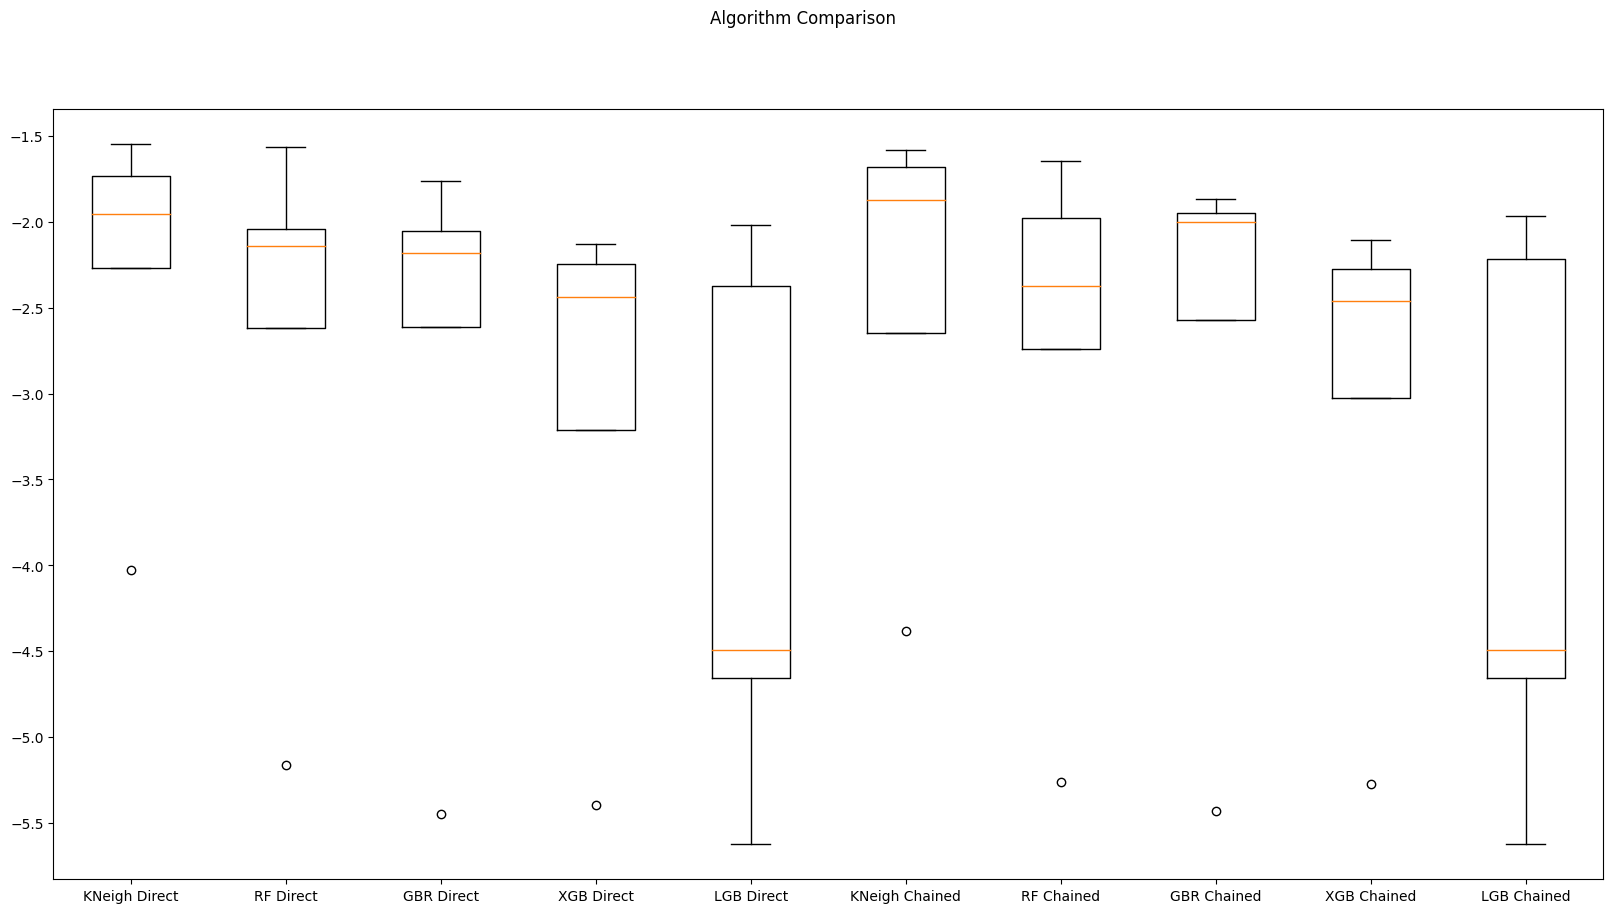

In [134]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(20,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [135]:
# prepare models to create predcitions
prediction_models = []

#direct Models
prediction_models.append(('KNeigh Direct', MultiOutputRegressor(KNeighborsRegressor())))
prediction_models.append(('RF Direct', MultiOutputRegressor(RandomForestRegressor())))
prediction_models.append(('GBR Chained', MultiOutputRegressor(GradientBoostingRegressor())))

In [136]:
# create a dataframe to store the multivariate predictions
multivariate_pred = pd.DataFrame(index=test_data.index)

#run the different ML models to create the predictions dataset
for name, model in prediction_models:
    model.fit(X_train, y_train)
    #create preictions for the next 12 months
    yhat = model.predict(X_test)
    multivariate_pred[name +'_predictions'] = yhat.flatten()


In [137]:
multivariate_pred

,KNeigh Direct_predictions,RF Direct_predictions,GBR Chained_predictions
Date Local,,,
2008-01-01,16.902,13.1236,9.306583
2008-02-01,22.064,20.6128,20.445111
2008-03-01,27.934,28.0313,27.263918
2008-04-01,29.704,30.2509,32.749404
2008-05-01,28.920,28.6577,30.397893
2008-06-01,24.398,24.3112,25.854511
2008-07-01,20.964,19.4124,19.426092
2008-08-01,22.204,23.0912,23.587395
2008-09-01,24.458,24.5040,25.292612


In [138]:
test_data

,O3 Mean,SO2 Mean,O3 AQI
Date Local,,,
2008-01-01,10.0,1.89,18.55
2008-02-01,20.0,1.46,22.24
2008-03-01,20.0,0.73,27.74
2008-04-01,30.0,0.67,35.90
2008-05-01,30.0,0.40,31.00
2008-06-01,30.0,0.68,27.57
2008-07-01,20.0,0.17,22.61
2008-08-01,20.0,0.46,19.55
2008-09-01,20.0,0.79,25.34


In [139]:
# creating columns for univariate predictions
# using dataframe.assign() function
univariate_multivariate_predictions = multivariate_pred.assign(triple_ets_add_pred=triple_ets_add_pred,
                                                               triple_ets_mul_pred=triple_ets_mul_pred,
                                                               sarima_pred=sarima_pred,
                                                               sarimax_pred=sarimax_pred,
                                                               var_pred = var_pred['Inverted Results O3 AQI'],
                                                               Actual_O3_AQI=test_data['O3 AQI'])


In [140]:
univariate_multivariate_predictions

,KNeigh Direct_predictions,RF Direct_predictions,GBR Chained_predictions,triple_ets_add_pred,triple_ets_mul_pred,sarima_pred,sarimax_pred,var_pred,Actual_O3_AQI
Date Local,,,,,,,,,
2008-01-01,16.902,13.1236,9.306583,15.409155,14.816572,16.854137,15.031068,16.986333,18.55
2008-02-01,22.064,20.6128,20.445111,22.550525,22.174888,22.232303,23.205369,23.723901,22.24
2008-03-01,27.934,28.0313,27.263918,28.618041,28.401748,28.454668,26.666091,26.907464,27.74
2008-04-01,29.704,30.2509,32.749404,32.598031,32.429327,30.686642,31.566290,29.369312,35.90
2008-05-01,28.920,28.6577,30.397893,30.818018,30.522374,30.890647,30.335028,32.526187,31.00
2008-06-01,24.398,24.3112,25.854511,25.591722,25.170327,23.423434,27.392538,23.078098,27.57
2008-07-01,20.964,19.4124,19.426092,20.525477,19.928648,19.056260,19.366386,17.798191,22.61
2008-08-01,22.204,23.0912,23.587395,22.771719,22.260315,22.546637,21.288807,21.877075,19.55
2008-09-01,24.458,24.5040,25.292612,25.792952,25.289251,25.838266,25.017233,26.565703,25.34


In [141]:
# add the multivariate metrics

metrics_dataframe = metrics_cal(test_data['O3 AQI'].values.flatten(),
                                univariate_multivariate_predictions['KNeigh Direct_predictions'].values.flatten(),
                                'KNN Direct')


metrics_dataframe = metrics_cal(test_data['O3 AQI'].values.flatten(),
                                univariate_multivariate_predictions['RF Direct_predictions'].values.flatten(),
                                'RF Direct')

metrics_dataframe = metrics_cal(test_data['O3 AQI'].values.flatten(),
                                univariate_multivariate_predictions['GBR Chained_predictions'].values.flatten(),
                                'GBR Chained')


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [142]:
metrics_dataframe

,Model,R2,RMSE,MAE,MAPE
0,Triple Add,0.874245,1.864755,1.425672,6.189420
0,Triple Mul,0.844590,2.072999,1.649735,7.239532
0,SARIMA,0.783698,2.445625,1.786451,7.277811
0,VAR,0.155354,4.832783,3.684167,13.903083
0,VAR_Diff12,0.682684,2.962144,2.349621,9.388767
0,SARIMAX,0.824703,2.201645,1.757271,7.752781
0,KNN Direct,0.781058,2.460507,1.903833,7.555071
0,RF Direct,0.669093,3.024913,2.530733,10.775882
0,GBR Chained,0.581191,3.403047,2.425486,11.166864


In [143]:
metrics_dataframe.sort_values(by="MAE", ascending=True)

,Model,R2,RMSE,MAE,MAPE
0,Triple Add,0.874245,1.864755,1.425672,6.189420
0,Triple Mul,0.844590,2.072999,1.649735,7.239532
0,SARIMAX,0.824703,2.201645,1.757271,7.752781
0,SARIMA,0.783698,2.445625,1.786451,7.277811
0,KNN Direct,0.781058,2.460507,1.903833,7.555071
0,VAR_Diff12,0.682684,2.962144,2.349621,9.388767
0,GBR Chained,0.581191,3.403047,2.425486,11.166864
0,RF Direct,0.669093,3.024913,2.530733,10.775882
0,VAR,0.155354,4.832783,3.684167,13.903083


In [144]:
univariate_multivariate_predictions.columns

Index(['KNeigh Direct_predictions', 'RF Direct_predictions',
       'GBR Chained_predictions', 'triple_ets_add_pred', 'triple_ets_mul_pred',
       'sarima_pred', 'sarimax_pred', 'var_pred', 'Actual_O3_AQI'],
      dtype='object')

In [145]:
# calculate average for the top 4 models - Triple Add, Triple Mul, KNN, SARIMAX

univariate_multivariate_predictions['Average'] = (univariate_multivariate_predictions['triple_ets_add_pred']+
                                                  univariate_multivariate_predictions['sarima_pred']+
                                                  univariate_multivariate_predictions['KNeigh Direct_predictions']+
                                                  univariate_multivariate_predictions['var_pred'])/4


univariate_multivariate_predictions

,KNeigh Direct_predictions,RF Direct_predictions,GBR Chained_predictions,triple_ets_add_pred,triple_ets_mul_pred,sarima_pred,sarimax_pred,var_pred,Actual_O3_AQI,Average
Date Local,,,,,,,,,,
2008-01-01,16.902,13.1236,9.306583,15.409155,14.816572,16.854137,15.031068,16.986333,18.55,16.537906
2008-02-01,22.064,20.6128,20.445111,22.550525,22.174888,22.232303,23.205369,23.723901,22.24,22.642682
2008-03-01,27.934,28.0313,27.263918,28.618041,28.401748,28.454668,26.666091,26.907464,27.74,27.978543
2008-04-01,29.704,30.2509,32.749404,32.598031,32.429327,30.686642,31.566290,29.369312,35.90,30.589496
2008-05-01,28.920,28.6577,30.397893,30.818018,30.522374,30.890647,30.335028,32.526187,31.00,30.788713
2008-06-01,24.398,24.3112,25.854511,25.591722,25.170327,23.423434,27.392538,23.078098,27.57,24.122813
2008-07-01,20.964,19.4124,19.426092,20.525477,19.928648,19.056260,19.366386,17.798191,22.61,19.585982
2008-08-01,22.204,23.0912,23.587395,22.771719,22.260315,22.546637,21.288807,21.877075,19.55,22.349858
2008-09-01,24.458,24.5040,25.292612,25.792952,25.289251,25.838266,25.017233,26.565703,25.34,25.663730


In [146]:
metrics_dataframe = metrics_cal(test_data['O3 AQI'].values.flatten(),
                                univariate_multivariate_predictions['Average'].values.flatten(),
                                'Average')

metrics_dataframe.sort_values(by="MAE", ascending=True)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Model,R2,RMSE,MAE,MAPE
0,Triple Add,0.874245,1.864755,1.425672,6.189420
0,Average,0.810405,2.289675,1.647101,6.674283
0,Triple Mul,0.844590,2.072999,1.649735,7.239532
0,SARIMAX,0.824703,2.201645,1.757271,7.752781
0,SARIMA,0.783698,2.445625,1.786451,7.277811
0,KNN Direct,0.781058,2.460507,1.903833,7.555071
0,VAR_Diff12,0.682684,2.962144,2.349621,9.388767
0,GBR Chained,0.581191,3.403047,2.425486,11.166864
0,RF Direct,0.669093,3.024913,2.530733,10.775882
0,VAR,0.155354,4.832783,3.684167,13.903083


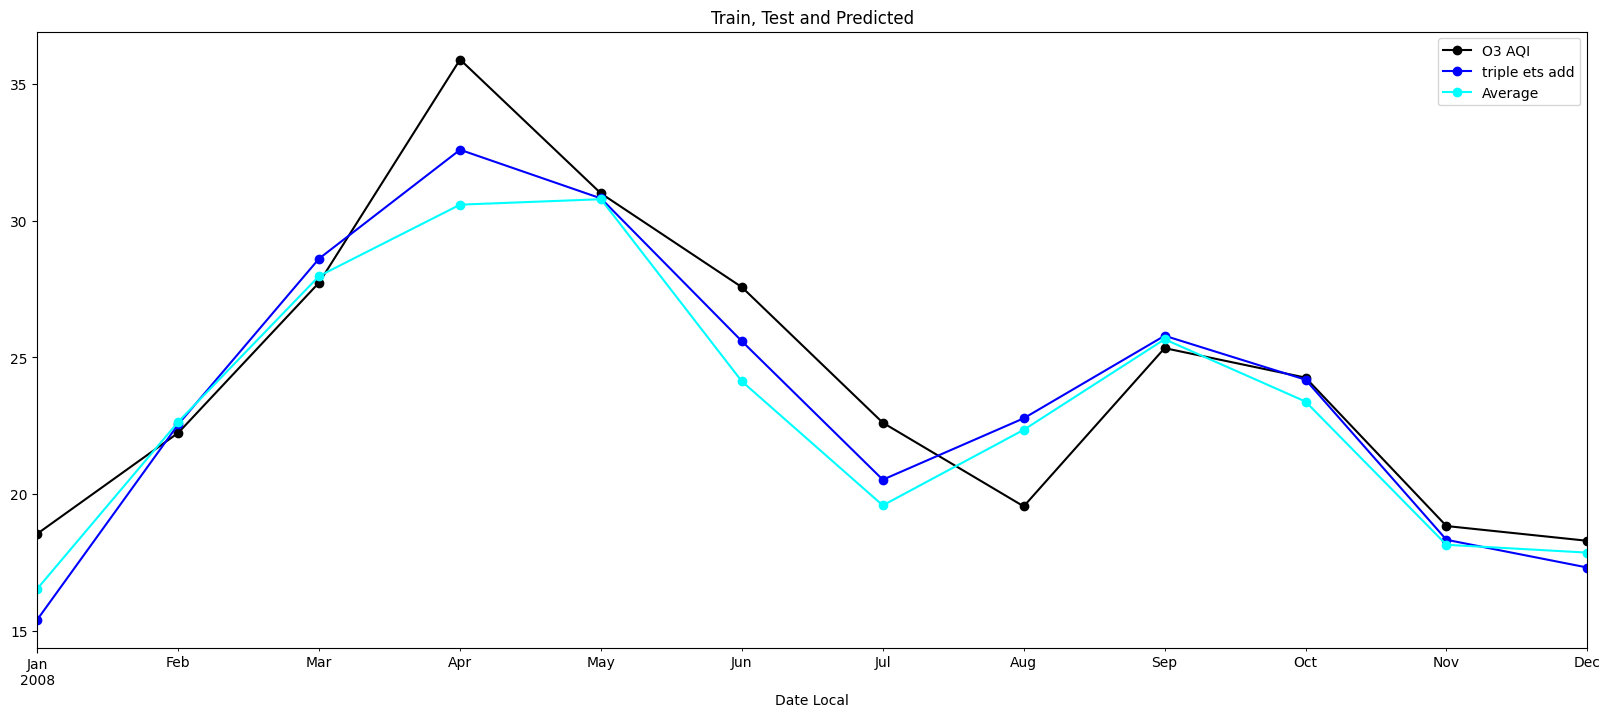

In [147]:
#plot the train, test, and predictions

#After creating model we will visualize the plot
#ax = train_data['O3 AQI'].plot(marker='o', color='black', figsize=(20,8), legend=True)
ax = test_data['O3 AQI'].plot(marker='o', color='black', figsize=(20,8), legend=True)

#train_data['O3 AQI'].plot(figsize=(20,8), legend=True)
#Plot for double ETS additive
triple_ets_add_pred.plot(marker='o', ax=ax, color='blue', legend=True, label = 'triple ets add')

#Plot for double ETS multiplicative
#triple_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label = 'triple ets mul')

#sarimax_pred['O3 AQI'].plot(marker='o', ax=ax, color='teal', legend=True, label = 'sarimax')

#univariate_multivariate_predictions['KNeigh Multi_predictions'].plot(marker='o', ax=ax, color='brown', legend=True, label = 'KNN')

univariate_multivariate_predictions['Average'].plot(marker='o', ax=ax, color='cyan', legend=True, label = 'Average')

plt.title('Train, Test and Predicted')
plt.show()